#### Data Aquisition and preprocessing

In [ ]:
%%R
library(GEOquery)
library(DESeq2)
library(dplyr)

# Load in data
gse = getGEO("GSE193677")

# Get metadata
metaData = pData(gse[[1]])

# Get disease status
class = substring(metaData$characteristics_ch1.4,14)

# Get Expression Data
expr_data = read.table("GSE193677_raw_counts_GRCh38.p13_NCBI.tsv",header=T)

# Make rownames Gene IDs
rownames(expr_data) = expr_data$GeneID

# remove Gene ID column
expr_data$GeneID = NULL

# find samples that are in metadata but not in the expression data
missing = setdiff(rownames(metaData),colnames(expr_data))

# find the indexes of these samples in the metadata
missing_id = which(rownames(metaData) %in% missing)

# remove from class
class_cln = data.frame(Class = class[-missing_id])
rownames(class_cln) = colnames(expr_data)


SyntaxError: invalid syntax (<ipython-input-2-01e29bd27062>, line 13)

#### DEG identification

In [ ]:
%%R
library(DESeq2)
# Define class levels
class_cln$Class = factor(class_cln$Class, levels = c("Control", "CD", "UC"))

# Remove lowly expressed genes
# Set minimum counts
min_counts = 10

# Define minimum number of samples with minimum number of counts. 10% of total
min_samples = ceiling(0.1 * ncol(expr_data))

# Take the rows that have at least 10 counts in 10 percent of samples
keep = which(rowSums(expr_data > min_counts) >  min_samples)

# Filter data
expr_data_filt = expr_data[keep,]

# Make DESeq dataset
dds = DESeqDataSetFromMatrix(countData = expr_data_filt,
                              colData = class_cln,
                              design= ~ Class)
# Find DEGS
dds <- DESeq(dds)

# Get the results
res_CD = results(dds, contrast = c("Class", "CD", "Control"))
res_UC = results(dds, contrast = c("Class", "UC", "Control"))
res_UC_vs_CD = results(dds, contrast = c("Class","CD","UC"))
# Find signifcant DEGS
sig_CD <- subset(res_CD, padj < 0.05 & abs(log2FoldChange) > 1)
sig_UC <- subset(res_UC, padj < 0.05 & abs(log2FoldChange) > 1)

# Quality check and visualizations
plotMA(res_CD)
plotMA(res_UC)
plotDispEsts(dds)
hist(results(dds)$pvalue, breaks=50)

# Volcano plot

# Convert to dataframe
res_UC_df = as.data.frame(res_UC)

# Add significance column
res_UC_df$Significance = "Not Significant"
# Define which genes are significant
res_UC_df$Significance[res_UC_df$padj < 0.05 & abs(res_UC_df$log2FoldChange) > 1] = "Significant"

library(ggplot2)

# Volcano plot for UC
ggplot(res_UC_df, aes(x=log2FoldChange, y=-log10(padj), color=Significance)) +
  geom_point(alpha=0.8, size=1.5) +
  scale_color_manual(values=c("gray", "red")) +
  theme_minimal() +
  labs(
    title = "Volcano Plot for CD",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted p-value"
  ) +
  theme(
    legend.title = element_blank(),
    legend.position = "top"
  )

# Volcano plot for CD

res_CD_df = as.data.frame(res_CD)
res_CD_df$Significance = "Not Significant"
res_CD_df$Significance[res_CD_df$padj < 0.05 & abs(res_CD_df$log2FoldChange) > 1] = "Significant"

ggplot(res_CD_df, aes(x=log2FoldChange, y=-log10(padj), color=Significance)) +
  geom_point(alpha=0.8, size=1.5) +
  scale_color_manual(values=c("gray", "red")) +
  theme_minimal() +
  labs(
    title = "Volcano Plot for CD",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted p-value"
  ) +
  theme(
    legend.title = element_blank(),
    legend.position = "top"
  )

# Plot PCA
# filter for significant DEGs
res = results(dds)
# Take top 40 genes
top_genes <- rownames(res[order(res$padj), ][1:40, ])

# Perform VST
vst_data = varianceStabilizingTransformation(dds, blind = TRUE)
vst_subset = vst_data[top_genes,]

# Plot PCA
plotPCA(vst_subset, intgroup = "Class")

#### Metadata Analysis

In [ ]:
%%R
# selected metadata
final.meta <- metaData[,c("ibd_disease:ch1",
  "demographics_gender:ch1",
  "study_eligibility_age_at_endo:ch1",
  "regionre:ch1",
  "typere:ch1",
  "crp_jjmgl_log2:ch1",
  "log2_fecalcalpro_mgperg:ch1",
  "ibd_clinicianmeasure_inactive_active:ch1",
  "ibd_endoseverity_4levels:ch1",
  "ibdmesuc_mayo_score:ch1",
  "max_nancy:ch1",
  "max_ghas_sum7:ch1")]

final.meta <- final.meta %>% rename(
 "Disease.type" = "ibd_disease:ch1", # UC, CD, Control
 "Sex" = "demographics_gender:ch1",
 "Age" = "study_eligibility_age_at_endo:ch1",
 "Tissue.region" = "regionre:ch1",
 "Inflamed.yn" = "typere:ch1", # NonI, I
 "log2_CRP" = "crp_jjmgl_log2:ch1", # C-reactive protein, IBD activity biomarker
 "log2_Calprotectin" = "log2_fecalcalpro_mgperg:ch1", # IBD activity biomarker
 "Clinically.Active" = "ibd_clinicianmeasure_inactive_active:ch1", # inactive disease: HBI < 5 or SCCAI < 5, active disease: HBI >7 or SSCAI >=5

 ### unsure if we should keep it
 "SESCD_Endoscopic.CD" = "ibd_endoseverity_4levels:ch1", # for Crohn's, Simple Endoscopic Score for Crohn’s Disease (SES-CD) - inactive (0–2), mild (3–6), moderate (7–15), and severe (≥16)
 "Mayo_Endoscopic.UC" = "ibdmesuc_mayo_score:ch1", # endoscopic measure for UC: normal/inactive disease (0); mild disease (1); moderate disease (2); or severe disease (3)
 "Max.Nancy_Histo.UC" = "max_nancy:ch1", # control and UC, histological scoring of disease activity
 "Max.GHAS_Histo.CD"  = "max_ghas_sum7:ch1", # control and CD,  General histology activity score, scoring disease activity
)

# Remove samples with no expression data
final.meta = final.meta[!(rownames(final.meta) %in% missing),]

#### Create final data frame for machine learning

In [ ]:
%%R
# Sort genes by adjusted p-value

pval_CD_sort = res_CD_df[order(res_CD_df$padj),]
pval_UC_sort = res_UC_df[order(res_UC_df$padj),]

# Take 200 of the most significant DEGS for each class
top_CD = rownames(pval_CD_sort)[1:200]
top_UC = rownames(pval_UC_sort)[1:200]

# Find the top unique genes
top_genes = unique(c(top_CD,top_UC))

# Pull these out of the expression data
top_expr = as.data.frame(t(expr_data[top_genes,]))

#Combine the metadata and expression data
model_data = cbind(final.meta, top_expr)



#### SVM

In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from sklearn.svm import SVC, LinearSVC  # Import specific classifiers
import pickle

In [ ]:
# Load the objects from the pickle file
with open('/content/241208_workspace.pkl', 'rb') as f: # or the pathname to the pickle
    loaded_objects = pickle.load(f)

## Accessing the objects from the loaded workspace
# random_search_rf_loaded = loaded_objects['random_search_rf']
# X_rem2_loaded = loaded_objects['X_rem2']
# y_rem2_loaded = loaded_objects['y_rem2']

In [ ]:
# Read the TSV file
model_data = pd.read_csv("/model_data.tsv", sep='\t')

In [ ]:
model_data.head() # this data is not normalized

Disease.type     Sex  Age Tissue.region Inflamed.yn  log2_CRP  \
GSM5976499           UC    Male   44        Rectum        NonI -1.733045   
GSM5976500           UC    Male   44     LeftColon        NonI -1.733045   
GSM5976501           UC    Male   44         Ileum        NonI -1.733045   
GSM5976502           CD  Female   60    RightColon        NonI  1.436490   
GSM5976503           CD  Female   60     LeftColon        NonI  1.436490   

            log2_Calprotectin Clinically.Active SESCD_Endoscopic.CD  \
GSM5976499                NaN          Inactive            Inactive   
GSM5976500                NaN          Inactive            Inactive   
GSM5976501                NaN          Inactive            Inactive   
GSM5976502            4.05398            Active            Inactive   
GSM5976503            4.05398            Active            Inactive   

            Mayo_Endoscopic.UC  ...   1281  28461  3651  414236  100996351  \
GSM5976499                 0.0  ...  16667    128    15      57         10   
GSM5976500                 0.0  ...   9664     43     2      25          3   
GSM5976501                 0.0  ...  17575    200     1      87          9   
GSM5976502                 NaN  ...  14589    145     4      81          7   
GSM5976503                 NaN  ...   6879     46     9      42          6   

            388125  79898  28915  4222  5271  
GSM5976499      26    264     12    65   306  
GSM5976500       5    169      3    18   151  
GSM5976501      11    191     37    85   296  
GSM5976502      13    440     34    31   223  
GSM5976503       4    439      5    25   190  

[5 rows x 312 columns]

In [ ]:
%%R
# we have 11 features: check how many have >50% !is.na
norm.data <- read.csv("ModelDataNormalized.tsv", sep="\t", header=T)
sum(is.na(norm.data[,c(14:ncol(norm.data))])) # no expression data missing
sapply(norm.data[,c(2:13)], function(df){
  paste0(sum(is.na(df)), " (",
         round(sum(is.na(df))/length(df)*100, 2), "%)", sep="")
})

# 2 cols with 65% and 78% missing so remove: 8, 11 (calprotectin and UC endoscopic)
# 2 cols with 43.8% missing: 12:13 (histologic scores)
# try a model without these 2 cols and a model with replacing NA's with median
norm.data.rem2 <- norm.data[,-c(8,11:13)]
norm.data.noNA <- norm.data[,-c(8,11)] %>% mutate(
  Max.Nancy_Histo.UC = case_when(
    is.na(Max.Nancy_Histo.UC) ~ median(norm.data$Max.Nancy_Histo.UC,
                                       na.rm = TRUE),
    TRUE ~ Max.Nancy_Histo.UC),
    Max.GHAS_Histo.CD = case_when(
      is.na(Max.GHAS_Histo.CD) ~ median(norm.data$Max.GHAS_Histo.CD,
                                        na.rm = TRUE),
      TRUE ~ Max.GHAS_Histo.CD
    )
)

# now we have 7-9 features
# find 34 total DEGs (17 from each without duplicates)
cd.deg <- read.csv("CD_DEGS_sorted_pval.txt", header = TRUE, sep = "\t")
uc.deg <- read.csv("UC_DEGS_sorted_pval.txt", header = TRUE, sep = "\t")

cd.deg <- cd.deg[order(cd.deg$padj),]
uc.deg <- uc.deg[order(uc.deg$padj),]


find.34 <- data.frame(
  GeneID = gsub("^X", "", colnames(norm.data.rem2[,c(10:ncol(norm.data.rem2))])),
  cd.deg.padj = NA,
  uc.deg.padj = NA
)

find.34$cd.deg.padj <- cd.deg$padj[match(find.34$GeneID, cd.deg$GeneID)]
find.34$uc.deg.padj <- uc.deg$padj[match(find.34$GeneID, uc.deg$GeneID)]
# write.csv(find.34, "241208_Match.Colnames.csv")

cd.deg.top20 <- head(find.34[order(find.34$cd.deg.padj),],20)
uc.deg.top20 <- head(find.34[order(find.34$uc.deg.padj),],20)

# checks if two sets contain the same elements, disregarding their order
setequal(cd.deg.top20$GeneID, uc.deg.top20$GeneID)
# which ones are not equal - Warning: 20 mismatches does not mean all are not equal
all.equal(cd.deg.top20$GeneID, uc.deg.top20$GeneID)

# all 20 are not the same so I can use the top 17 from each

cd.deg.top17 <- head(find.34[order(find.34$cd.deg.padj),],17)

uc.deg.find17 <- find.34[order(find.34$uc.deg.padj),]
uc.deg.find17 <- uc.deg.find17[!(uc.deg.find17$GeneID %in% cd.deg.top17$GeneID),]
uc.deg.top17 <- head(uc.deg.find17, 17)

keep.34 <- rbind(cd.deg.top17, uc.deg.top17)
# Add 'X' in front of each GeneID to match back
keep.34$GeneID <- paste0("X", keep.34$GeneID)


# filter model data for just the 34 genes
norm.data.rem2.cut <- norm.data.rem2[,c(1:9,
                                        which(colnames(norm.data.rem2) %in%
                                                keep.34$GeneID))]


norm.data.noNA.cut <- norm.data.noNA[,c(1:11,
                                        which(colnames(norm.data.noNA) %in%
                                                keep.34$GeneID))]

# write.csv(norm.data.rem2.cut, "241208_Norm.data.Rem2.csv")
# write.csv(norm.data.noNA.cut, "241208_Norm.data.NoNA.csv")

In [ ]:
# now we have 41-43 features:
## norm_rem2 has 41 features because we removed 2 with 43% NA
## norm_noNA has 43 features because we kept the 2 cols and replaced NA's with the col's median


norm_rem2 = pd.read_csv("/content/241208_Norm.data.Rem2.csv")
# use set_index to make the ID column my index for the df
norm_rem2 = norm_rem2.set_index('ID')
norm_rem2.head()

Disease.type     Sex  Age Tissue.region Inflamed.yn  log2_CRP  \
ID                                                                         
GSM5976499           UC    Male   44        Rectum        NonI -1.733045   
GSM5976500           UC    Male   44     LeftColon        NonI -1.733045   
GSM5976501           UC    Male   44         Ileum        NonI -1.733045   
GSM5976502           CD  Female   60    RightColon        NonI  1.436490   
GSM5976503           CD  Female   60     LeftColon        NonI  1.436490   

           Clinically.Active SESCD_Endoscopic.CD     X2346     X1116  ...  \
ID                                                                    ...   
GSM5976499          Inactive            Inactive -0.734807 -0.239503  ...   
GSM5976500          Inactive            Inactive -0.798520 -0.661091  ...   
GSM5976501          Inactive            Inactive  0.220419  0.206250  ...   
GSM5976502            Active            Inactive  0.617282 -0.735794  ...   
GSM5976503            Active            Inactive -0.618784 -0.662444  ...   

               X4586     X4319     X3502     X4316     X3855     X3500  \
ID                                                                       
GSM5976499  0.816403 -0.609817  0.387815 -0.110065 -0.081105  0.785482   
GSM5976500 -0.475171 -1.190500 -0.819715 -0.942298 -0.273055 -0.933020   
GSM5976501 -0.721310 -1.190500  1.236697  0.505472 -0.824398  1.434299   
GSM5976502 -0.723736 -0.327821 -0.864031 -0.698956 -0.641507 -0.468309   
GSM5976503 -0.684677 -0.160902 -0.945777 -0.493108 -0.885334 -0.547335   

              X26154     X8710     X5655    X28454  
ID                                                  
GSM5976499  0.696046  1.513917 -0.102172  0.265163  
GSM5976500 -0.671092 -0.605820 -0.151610 -0.938057  
GSM5976501 -0.552254 -0.605820 -0.394379  0.501208  
GSM5976502 -0.812577 -0.605820 -0.497456 -0.623298  
GSM5976503 -0.665613 -0.605820  0.009752 -0.999135  

[5 rows x 42 columns]

In [ ]:
norm_noNA = pd.read_csv("/content/241208_Norm.data.NoNA.csv")
norm_noNA = norm_noNA.set_index('ID')
norm_noNA.head()

Disease.type     Sex  Age Tissue.region Inflamed.yn  log2_CRP  \
ID                                                                         
GSM5976499           UC    Male   44        Rectum        NonI -1.733045   
GSM5976500           UC    Male   44     LeftColon        NonI -1.733045   
GSM5976501           UC    Male   44         Ileum        NonI -1.733045   
GSM5976502           CD  Female   60    RightColon        NonI  1.436490   
GSM5976503           CD  Female   60     LeftColon        NonI  1.436490   

           Clinically.Active SESCD_Endoscopic.CD  Max.Nancy_Histo.UC  \
ID                                                                     
GSM5976499          Inactive            Inactive                   0   
GSM5976500          Inactive            Inactive                   0   
GSM5976501          Inactive            Inactive                   0   
GSM5976502            Active            Inactive                   0   
GSM5976503            Active            Inactive                   0   

            Max.GHAS_Histo.CD  ...     X4586     X4319     X3502     X4316  \
ID                             ...                                           
GSM5976499                  2  ...  0.816403 -0.609817  0.387815 -0.110065   
GSM5976500                  2  ... -0.475171 -1.190500 -0.819715 -0.942298   
GSM5976501                  2  ... -0.721310 -1.190500  1.236697  0.505472   
GSM5976502                  1  ... -0.723736 -0.327821 -0.864031 -0.698956   
GSM5976503                  1  ... -0.684677 -0.160902 -0.945777 -0.493108   

               X3855     X3500    X26154     X8710     X5655    X28454  
ID                                                                      
GSM5976499 -0.081105  0.785482  0.696046  1.513917 -0.102172  0.265163  
GSM5976500 -0.273055 -0.933020 -0.671092 -0.605820 -0.151610 -0.938057  
GSM5976501 -0.824398  1.434299 -0.552254 -0.605820 -0.394379  0.501208  
GSM5976502 -0.641507 -0.468309 -0.812577 -0.605820 -0.497456 -0.623298  
GSM5976503 -0.885334 -0.547335 -0.665613 -0.605820  0.009752 -0.999135  

[5 rows x 44 columns]

In [ ]:
# set my X and y for both sets, one-hot encoding the y's

# The algorithm requires the variables to be coded into its equivalent integer codes
# We can convert the string categorical values into an integer code using numpy
# setting 2 objects: vals and y2
# where vals = np.unique(y['diagnosis'].values - an array of the unique values in Diagnosis col
# and y = an inverse array of the col - where 0,1 values are attributed to the
## values in the col based on the unique values, and y is a map of the original col but in 0,1's
vals_rem2, y_rem2 = np.unique(norm_rem2['Disease.type'].values, return_inverse=True)
vals_rem2

array(['CD', 'Control', 'UC'], dtype=object)

In [ ]:
y_rem2 # 0: CD, 1: Control, 2: UC

array([2, 2, 2, ..., 1, 1, 1])

In [ ]:
# save my hc_cf_top10 df as a new object called X so I can store the gene expression values
X_rem2 = norm_rem2
# use pop to remove the Y column and save only the gene expression values as my X df
X_rem2.pop('Disease.type')
X_rem2.head()

Sex  Age Tissue.region Inflamed.yn  log2_CRP Clinically.Active  \
ID                                                                              
GSM5976499    Male   44        Rectum        NonI -1.733045          Inactive   
GSM5976500    Male   44     LeftColon        NonI -1.733045          Inactive   
GSM5976501    Male   44         Ileum        NonI -1.733045          Inactive   
GSM5976502  Female   60    RightColon        NonI  1.436490            Active   
GSM5976503  Female   60     LeftColon        NonI  1.436490            Active   

           SESCD_Endoscopic.CD     X2346     X1116     X2215  ...     X4586  \
ID                                                            ...             
GSM5976499            Inactive -0.734807 -0.239503 -0.795064  ...  0.816403   
GSM5976500            Inactive -0.798520 -0.661091 -1.133618  ... -0.475171   
GSM5976501            Inactive  0.220419  0.206250 -0.501224  ... -0.721310   
GSM5976502            Inactive  0.617282 -0.735794 -0.615965  ... -0.723736   
GSM5976503            Inactive -0.618784 -0.662444 -0.820484  ... -0.684677   

               X4319     X3502     X4316     X3855     X3500    X26154  \
ID                                                                       
GSM5976499 -0.609817  0.387815 -0.110065 -0.081105  0.785482  0.696046   
GSM5976500 -1.190500 -0.819715 -0.942298 -0.273055 -0.933020 -0.671092   
GSM5976501 -1.190500  1.236697  0.505472 -0.824398  1.434299 -0.552254   
GSM5976502 -0.327821 -0.864031 -0.698956 -0.641507 -0.468309 -0.812577   
GSM5976503 -0.160902 -0.945777 -0.493108 -0.885334 -0.547335 -0.665613   

               X8710     X5655    X28454  
ID                                        
GSM5976499  1.513917 -0.102172  0.265163  
GSM5976500 -0.605820 -0.151610 -0.938057  
GSM5976501 -0.605820 -0.394379  0.501208  
GSM5976502 -0.605820 -0.497456 -0.623298  
GSM5976503 -0.605820  0.009752 -0.999135  

[5 rows x 41 columns]

In [ ]:
vals_noNA, y_noNA = np.unique(norm_noNA['Disease.type'].values, return_inverse=True)
vals_noNA

array(['CD', 'Control', 'UC'], dtype=object)

In [ ]:
y_noNA

array([2, 2, 2, ..., 1, 1, 1])

In [ ]:
X_noNA = norm_noNA
X_noNA.pop('Disease.type')
X_noNA.head()

Sex  Age Tissue.region Inflamed.yn  log2_CRP Clinically.Active  \
ID                                                                              
GSM5976499    Male   44        Rectum        NonI -1.733045          Inactive   
GSM5976500    Male   44     LeftColon        NonI -1.733045          Inactive   
GSM5976501    Male   44         Ileum        NonI -1.733045          Inactive   
GSM5976502  Female   60    RightColon        NonI  1.436490            Active   
GSM5976503  Female   60     LeftColon        NonI  1.436490            Active   

           SESCD_Endoscopic.CD  Max.Nancy_Histo.UC  Max.GHAS_Histo.CD  \
ID                                                                      
GSM5976499            Inactive                   0                  2   
GSM5976500            Inactive                   0                  2   
GSM5976501            Inactive                   0                  2   
GSM5976502            Inactive                   0                  1   
GSM5976503            Inactive                   0                  1   

               X2346  ...     X4586     X4319     X3502     X4316     X3855  \
ID                    ...                                                     
GSM5976499 -0.734807  ...  0.816403 -0.609817  0.387815 -0.110065 -0.081105   
GSM5976500 -0.798520  ... -0.475171 -1.190500 -0.819715 -0.942298 -0.273055   
GSM5976501  0.220419  ... -0.721310 -1.190500  1.236697  0.505472 -0.824398   
GSM5976502  0.617282  ... -0.723736 -0.327821 -0.864031 -0.698956 -0.641507   
GSM5976503 -0.618784  ... -0.684677 -0.160902 -0.945777 -0.493108 -0.885334   

               X3500    X26154     X8710     X5655    X28454  
ID                                                            
GSM5976499  0.785482  0.696046  1.513917 -0.102172  0.265163  
GSM5976500 -0.933020 -0.671092 -0.605820 -0.151610 -0.938057  
GSM5976501  1.434299 -0.552254 -0.605820 -0.394379  0.501208  
GSM5976502 -0.468309 -0.812577 -0.605820 -0.497456 -0.623298  
GSM5976503 -0.547335 -0.665613 -0.605820  0.009752 -0.999135  

[5 rows x 43 columns]

In [ ]:
print(X_noNA.columns)

Index(['Sex', 'Age', 'Tissue.region', 'Inflamed.yn', 'log2_CRP',
       'Clinically.Active', 'SESCD_Endoscopic.CD', 'Max.Nancy_Histo.UC',
       'Max.GHAS_Histo.CD', 'X2346', 'X1116', 'X2215', 'X29881', 'X6289',
       'X6279', 'X219595', 'X6288', 'X366', 'X2358', 'X100528017', 'X405753',
       'X4843', 'X3620', 'X3772', 'X2357', 'X6280', 'X90527', 'X4314', 'X6947',
       'X50506', 'X387129', 'X79931', 'X3505', 'X4586', 'X4319', 'X3502',
       'X4316', 'X3855', 'X3500', 'X26154', 'X8710', 'X5655', 'X28454'],
      dtype='object')


In [ ]:
print(X_rem2.columns)

Index(['Sex', 'Age', 'Tissue.region', 'Inflamed.yn', 'log2_CRP',
       'Clinically.Active', 'SESCD_Endoscopic.CD', 'X2346', 'X1116', 'X2215',
       'X29881', 'X6289', 'X6279', 'X219595', 'X6288', 'X366', 'X2358',
       'X100528017', 'X405753', 'X4843', 'X3620', 'X3772', 'X2357', 'X6280',
       'X90527', 'X4314', 'X6947', 'X50506', 'X387129', 'X79931', 'X3505',
       'X4586', 'X4319', 'X3502', 'X4316', 'X3855', 'X3500', 'X26154', 'X8710',
       'X5655', 'X28454'],
      dtype='object')


In [ ]:
# need to factorize all categorical variables to integer equivalents
cols_to_factorize = [0, 2, 3, 5, 6]

# Dictionary to store the mappings for each column
category_mapping = {}

# Factorize each of the specified columns
for idx in cols_to_factorize:
    col_name = X_rem2.columns[idx]  # Get the actual column name by index
    # Factorize the column to get the numerical labels and the unique categories
    new_col, labels = pd.factorize(X_rem2[col_name])

    # Replace the original column with the numerical labels
    X_rem2[col_name] = new_col

    # Store the mapping (dictionary) of numerical labels to original categories
    category_mapping[col_name] = dict(enumerate(labels))

# Show the modified DataFrame and the mappings for each column
print(X_rem2.head())
print("\nCategory Mappings:", category_mapping)

            Sex  Age  Tissue.region  Inflamed.yn  log2_CRP  Clinically.Active  \
ID                                                                              
GSM5976499    0   44              0            0 -1.733045                  0   
GSM5976500    0   44              1            0 -1.733045                  0   
GSM5976501    0   44              2            0 -1.733045                  0   
GSM5976502    1   60              3            0  1.436490                  1   
GSM5976503    1   60              1            0  1.436490                  1   

            SESCD_Endoscopic.CD     X2346     X1116     X2215  ...     X4586  \
ID                                                             ...             
GSM5976499                    0 -0.734807 -0.239503 -0.795064  ...  0.816403   
GSM5976500                    0 -0.798520 -0.661091 -1.133618  ... -0.475171   
GSM5976501                    0  0.220419  0.206250 -0.501224  ... -0.721310   
GSM5976502                    0 

In [ ]:
X_rem2[X_rem2.isna().any(axis=1)]

Sex  Age  Tissue.region  Inflamed.yn  log2_CRP  Clinically.Active  \
ID                                                                              
GSM5976515    1   32              2            0       NaN                 -1   
GSM5976516    1   32              0            0       NaN                 -1   
GSM5976596    1   46              0            0       NaN                  0   
GSM5976607    1   54              0            1       NaN                  0   
GSM5976608    1   54              6            0       NaN                  0   
...         ...  ...            ...          ...       ...                ...   
GSM5978853    1   21              0            1       NaN                  0   
GSM5978854    1   21              2            0       NaN                  0   
GSM5978918    1   71              0            0       NaN                 -1   
GSM5978929    1   61              6            0       NaN                 -1   
GSM5978930    1   61              0            0       NaN                 -1   

            SESCD_Endoscopic.CD     X2346     X1116     X2215  ...     X4586  \
ID                                                             ...             
GSM5976515                    0  1.157925 -0.815981 -0.441058  ... -0.896705   
GSM5976516                    0 -0.571475 -1.010013 -0.608151  ... -0.382111   
GSM5976596                    2  3.645918 -0.545475  0.466389  ... -0.145562   
GSM5976607                    3  0.006387  1.827820  2.406125  ... -0.583454   
GSM5976608                    3 -0.521623 -0.647447 -0.580656  ...  0.183030   
...                         ...       ...       ...       ...  ...       ...   
GSM5978853                    1 -0.222561  1.986696  1.954445  ...  0.822554   
GSM5978854                    1  3.269520 -0.298827  0.626795  ... -0.549691   
GSM5978918                   -1 -0.644612 -0.688761 -0.755336  ...  0.175275   
GSM5978929                   -1 -0.686691 -0.418322 -0.791771  ... -0.478486   
GSM5978930                   -1  0.071240 -0.484228 -0.150165  ... -0.557121   

               X4319     X3502     X4316     X3855     X3500    X26154  \
ID                                                                       
GSM5976515 -0.464396 -0.243845  0.169327 -0.564060  0.058332 -0.535377   
GSM5976516 -0.657848 -0.124110 -0.272406 -0.527288  0.130273 -0.372930   
GSM5976596 -0.802623 -0.293397 -0.592342 -1.421423 -0.221835 -0.645136   
GSM5976607  2.906825  0.415974  1.484064  1.341023  0.209769  0.443566   
GSM5976608  0.133389 -1.806640 -0.942298  0.247851 -2.123592 -0.690649   
...              ...       ...       ...       ...       ...       ...   
GSM5978853  2.243394  1.138906  2.105906  1.383698  0.924208  1.679442   
GSM5978854 -0.227563  0.626093 -0.313254 -0.506000  0.412418 -0.614895   
GSM5978918 -0.494977 -0.515880 -0.416103 -1.161969 -0.303064 -0.312124   
GSM5978929 -0.889583 -0.104294 -0.117563 -0.642348 -0.296036 -0.646042   
GSM5978930 -1.190500  0.457412 -0.502246 -0.896330  0.023242 -0.866420   

               X8710     X5655    X28454  
ID                                        
GSM5976515 -0.605820  0.419377 -0.838333  
GSM5976516 -0.605820 -0.418659 -0.318572  
GSM5976596 -0.063070 -1.021310 -0.717501  
GSM5976607  3.809759  3.164654  0.440286  
GSM5976608 -0.173077 -0.183480 -0.826643  
...              ...       ...       ...  
GSM5978853  2.081734 -0.075008  0.359447  
GSM5978854 -0.288321 -0.403884  0.354409  
GSM5978918 -0.408749 -0.551387 -0.256442  
GSM5978929 -0.183455 -0.437389  0.149760  
GSM5978930 -0.605820 -0.248026 -0.258719  

[89 rows x 41 columns]

In [ ]:
rows_with_na_indices = X_rem2[X_rem2.isna().any(axis=1)].index

In [ ]:
category_mapping_noNA = {}

# Factorize each of the specified columns
for idx in cols_to_factorize:
    col_name = X_noNA.columns[idx]  # Get the actual column name by index
    # Factorize the column to get the numerical labels and the unique categories
    new_col, labels = pd.factorize(X_noNA[col_name])

    # Replace the original column with the numerical labels
    X_noNA[col_name] = new_col

    # Store the mapping (dictionary) of numerical labels to original categories
    category_mapping_noNA[col_name] = dict(enumerate(labels))

# Show the modified DataFrame and the mappings for each column
print(X_noNA.head())
print("\nCategory Mappings:", category_mapping_noNA)

            Sex  Age  Tissue.region  Inflamed.yn  log2_CRP  Clinically.Active  \
ID                                                                              
GSM5976499    0   44              0            0 -1.733045                  0   
GSM5976500    0   44              1            0 -1.733045                  0   
GSM5976501    0   44              2            0 -1.733045                  0   
GSM5976502    1   60              3            0  1.436490                  1   
GSM5976503    1   60              1            0  1.436490                  1   

            SESCD_Endoscopic.CD  Max.Nancy_Histo.UC  Max.GHAS_Histo.CD  \
ID                                                                       
GSM5976499                    0                   0                  2   
GSM5976500                    0                   0                  2   
GSM5976501                    0                   0                  2   
GSM5976502                    0                   0           

In [ ]:
# Function to replace NaN with median (for continuous columns) or mode (for categorical columns)
def my_replace_na(df):
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:  # Continuous column (numeric)
            # Directly modify the column using df.loc
            df.loc[:, col] = df[col].fillna(df[col].median())  # Avoid chained assignment
        elif df[col].dtype == 'object':  # Categorical column (string or object type)
            mode_val = df[col].mode()[0]  # Mode returns a Series, get the first value
            # Directly modify the column using df.loc
            df.loc[:, col] = df[col].fillna(mode_val)  # Avoid chained assignment
    return df

# Apply the function to replace NaNs
X_rem2 = my_replace_na(X_rem2)
X_rem2.head()

Sex  Age  Tissue.region  Inflamed.yn  log2_CRP  Clinically.Active  \
ID                                                                              
GSM5976499    0   44              0            0 -1.733045                  0   
GSM5976500    0   44              1            0 -1.733045                  0   
GSM5976501    0   44              2            0 -1.733045                  0   
GSM5976502    1   60              3            0  1.436490                  1   
GSM5976503    1   60              1            0  1.436490                  1   

            SESCD_Endoscopic.CD     X2346     X1116     X2215  ...     X4586  \
ID                                                             ...             
GSM5976499                    0 -0.734807 -0.239503 -0.795064  ...  0.816403   
GSM5976500                    0 -0.798520 -0.661091 -1.133618  ... -0.475171   
GSM5976501                    0  0.220419  0.206250 -0.501224  ... -0.721310   
GSM5976502                    0  0.617282 -0.735794 -0.615965  ... -0.723736   
GSM5976503                    0 -0.618784 -0.662444 -0.820484  ... -0.684677   

               X4319     X3502     X4316     X3855     X3500    X26154  \
ID                                                                       
GSM5976499 -0.609817  0.387815 -0.110065 -0.081105  0.785482  0.696046   
GSM5976500 -1.190500 -0.819715 -0.942298 -0.273055 -0.933020 -0.671092   
GSM5976501 -1.190500  1.236697  0.505472 -0.824398  1.434299 -0.552254   
GSM5976502 -0.327821 -0.864031 -0.698956 -0.641507 -0.468309 -0.812577   
GSM5976503 -0.160902 -0.945777 -0.493108 -0.885334 -0.547335 -0.665613   

               X8710     X5655    X28454  
ID                                        
GSM5976499  1.513917 -0.102172  0.265163  
GSM5976500 -0.605820 -0.151610 -0.938057  
GSM5976501 -0.605820 -0.394379  0.501208  
GSM5976502 -0.605820 -0.497456 -0.623298  
GSM5976503 -0.605820  0.009752 -0.999135  

[5 rows x 41 columns]

In [ ]:
X_rem2.loc[rows_with_na_indices]

Sex  Age  Tissue.region  Inflamed.yn  log2_CRP  Clinically.Active  \
ID                                                                              
GSM5976515    1   32              2            0  1.930563                 -1   
GSM5976516    1   32              0            0  1.930563                 -1   
GSM5976596    1   46              0            0  1.930563                  0   
GSM5976607    1   54              0            1  1.930563                  0   
GSM5976608    1   54              6            0  1.930563                  0   
...         ...  ...            ...          ...       ...                ...   
GSM5978853    1   21              0            1  1.930563                  0   
GSM5978854    1   21              2            0  1.930563                  0   
GSM5978918    1   71              0            0  1.930563                 -1   
GSM5978929    1   61              6            0  1.930563                 -1   
GSM5978930    1   61              0            0  1.930563                 -1   

            SESCD_Endoscopic.CD     X2346     X1116     X2215  ...     X4586  \
ID                                                             ...             
GSM5976515                    0  1.157925 -0.815981 -0.441058  ... -0.896705   
GSM5976516                    0 -0.571475 -1.010013 -0.608151  ... -0.382111   
GSM5976596                    2  3.645918 -0.545475  0.466389  ... -0.145562   
GSM5976607                    3  0.006387  1.827820  2.406125  ... -0.583454   
GSM5976608                    3 -0.521623 -0.647447 -0.580656  ...  0.183030   
...                         ...       ...       ...       ...  ...       ...   
GSM5978853                    1 -0.222561  1.986696  1.954445  ...  0.822554   
GSM5978854                    1  3.269520 -0.298827  0.626795  ... -0.549691   
GSM5978918                   -1 -0.644612 -0.688761 -0.755336  ...  0.175275   
GSM5978929                   -1 -0.686691 -0.418322 -0.791771  ... -0.478486   
GSM5978930                   -1  0.071240 -0.484228 -0.150165  ... -0.557121   

               X4319     X3502     X4316     X3855     X3500    X26154  \
ID                                                                       
GSM5976515 -0.464396 -0.243845  0.169327 -0.564060  0.058332 -0.535377   
GSM5976516 -0.657848 -0.124110 -0.272406 -0.527288  0.130273 -0.372930   
GSM5976596 -0.802623 -0.293397 -0.592342 -1.421423 -0.221835 -0.645136   
GSM5976607  2.906825  0.415974  1.484064  1.341023  0.209769  0.443566   
GSM5976608  0.133389 -1.806640 -0.942298  0.247851 -2.123592 -0.690649   
...              ...       ...       ...       ...       ...       ...   
GSM5978853  2.243394  1.138906  2.105906  1.383698  0.924208  1.679442   
GSM5978854 -0.227563  0.626093 -0.313254 -0.506000  0.412418 -0.614895   
GSM5978918 -0.494977 -0.515880 -0.416103 -1.161969 -0.303064 -0.312124   
GSM5978929 -0.889583 -0.104294 -0.117563 -0.642348 -0.296036 -0.646042   
GSM5978930 -1.190500  0.457412 -0.502246 -0.896330  0.023242 -0.866420   

               X8710     X5655    X28454  
ID                                        
GSM5976515 -0.605820  0.419377 -0.838333  
GSM5976516 -0.605820 -0.418659 -0.318572  
GSM5976596 -0.063070 -1.021310 -0.717501  
GSM5976607  3.809759  3.164654  0.440286  
GSM5976608 -0.173077 -0.183480 -0.826643  
...              ...       ...       ...  
GSM5978853  2.081734 -0.075008  0.359447  
GSM5978854 -0.288321 -0.403884  0.354409  
GSM5978918 -0.408749 -0.551387 -0.256442  
GSM5978929 -0.183455 -0.437389  0.149760  
GSM5978930 -0.605820 -0.248026 -0.258719  

[89 rows x 41 columns]

In [ ]:
X_noNA[X_noNA.isna().any(axis=1)]

Sex  Age  Tissue.region  Inflamed.yn  log2_CRP  Clinically.Active  \
ID                                                                              
GSM5976515    1   32              2            0       NaN                 -1   
GSM5976516    1   32              0            0       NaN                 -1   
GSM5976596    1   46              0            0       NaN                  0   
GSM5976607    1   54              0            1       NaN                  0   
GSM5976608    1   54              6            0       NaN                  0   
...         ...  ...            ...          ...       ...                ...   
GSM5978853    1   21              0            1       NaN                  0   
GSM5978854    1   21              2            0       NaN                  0   
GSM5978918    1   71              0            0       NaN                 -1   
GSM5978929    1   61              6            0       NaN                 -1   
GSM5978930    1   61              0            0       NaN                 -1   

            SESCD_Endoscopic.CD  Max.Nancy_Histo.UC  Max.GHAS_Histo.CD  \
ID                                                                       
GSM5976515                    0                   0                  0   
GSM5976516                    0                   0                  0   
GSM5976596                    2                   0                  0   
GSM5976607                    3                   2                  4   
GSM5976608                    3                   2                  4   
...                         ...                 ...                ...   
GSM5978853                    1                   2                  6   
GSM5978854                    1                   2                  6   
GSM5978918                   -1                   0                  0   
GSM5978929                   -1                   0                  1   
GSM5978930                   -1                   0                  1   

               X2346  ...     X4586     X4319     X3502     X4316     X3855  \
ID                    ...                                                     
GSM5976515  1.157925  ... -0.896705 -0.464396 -0.243845  0.169327 -0.564060   
GSM5976516 -0.571475  ... -0.382111 -0.657848 -0.124110 -0.272406 -0.527288   
GSM5976596  3.645918  ... -0.145562 -0.802623 -0.293397 -0.592342 -1.421423   
GSM5976607  0.006387  ... -0.583454  2.906825  0.415974  1.484064  1.341023   
GSM5976608 -0.521623  ...  0.183030  0.133389 -1.806640 -0.942298  0.247851   
...              ...  ...       ...       ...       ...       ...       ...   
GSM5978853 -0.222561  ...  0.822554  2.243394  1.138906  2.105906  1.383698   
GSM5978854  3.269520  ... -0.549691 -0.227563  0.626093 -0.313254 -0.506000   
GSM5978918 -0.644612  ...  0.175275 -0.494977 -0.515880 -0.416103 -1.161969   
GSM5978929 -0.686691  ... -0.478486 -0.889583 -0.104294 -0.117563 -0.642348   
GSM5978930  0.071240  ... -0.557121 -1.190500  0.457412 -0.502246 -0.896330   

               X3500    X26154     X8710     X5655    X28454  
ID                                                            
GSM5976515  0.058332 -0.535377 -0.605820  0.419377 -0.838333  
GSM5976516  0.130273 -0.372930 -0.605820 -0.418659 -0.318572  
GSM5976596 -0.221835 -0.645136 -0.063070 -1.021310 -0.717501  
GSM5976607  0.209769  0.443566  3.809759  3.164654  0.440286  
GSM5976608 -2.123592 -0.690649 -0.173077 -0.183480 -0.826643  
...              ...       ...       ...       ...       ...  
GSM5978853  0.924208  1.679442  2.081734 -0.075008  0.359447  
GSM5978854  0.412418 -0.614895 -0.288321 -0.403884  0.354409  
GSM5978918 -0.303064 -0.312124 -0.408749 -0.551387 -0.256442  
GSM5978929 -0.296036 -0.646042 -0.183455 -0.437389  0.149760  
GSM5978930  0.023242 -0.866420 -0.605820 -0.248026 -0.258719  

[89 rows x 43 columns]

In [ ]:
rows_with_na_noNA = X_noNA[X_noNA.isna().any(axis=1)].index

In [ ]:
# Apply the function to replace NaNs
X_noNA = my_replace_na(X_noNA)
X_noNA.loc[rows_with_na_noNA]

Sex  Age  Tissue.region  Inflamed.yn  log2_CRP  Clinically.Active  \
ID                                                                              
GSM5976515    1   32              2            0  1.930563                 -1   
GSM5976516    1   32              0            0  1.930563                 -1   
GSM5976596    1   46              0            0  1.930563                  0   
GSM5976607    1   54              0            1  1.930563                  0   
GSM5976608    1   54              6            0  1.930563                  0   
...         ...  ...            ...          ...       ...                ...   
GSM5978853    1   21              0            1  1.930563                  0   
GSM5978854    1   21              2            0  1.930563                  0   
GSM5978918    1   71              0            0  1.930563                 -1   
GSM5978929    1   61              6            0  1.930563                 -1   
GSM5978930    1   61              0            0  1.930563                 -1   

            SESCD_Endoscopic.CD  Max.Nancy_Histo.UC  Max.GHAS_Histo.CD  \
ID                                                                       
GSM5976515                    0                   0                  0   
GSM5976516                    0                   0                  0   
GSM5976596                    2                   0                  0   
GSM5976607                    3                   2                  4   
GSM5976608                    3                   2                  4   
...                         ...                 ...                ...   
GSM5978853                    1                   2                  6   
GSM5978854                    1                   2                  6   
GSM5978918                   -1                   0                  0   
GSM5978929                   -1                   0                  1   
GSM5978930                   -1                   0                  1   

               X2346  ...     X4586     X4319     X3502     X4316     X3855  \
ID                    ...                                                     
GSM5976515  1.157925  ... -0.896705 -0.464396 -0.243845  0.169327 -0.564060   
GSM5976516 -0.571475  ... -0.382111 -0.657848 -0.124110 -0.272406 -0.527288   
GSM5976596  3.645918  ... -0.145562 -0.802623 -0.293397 -0.592342 -1.421423   
GSM5976607  0.006387  ... -0.583454  2.906825  0.415974  1.484064  1.341023   
GSM5976608 -0.521623  ...  0.183030  0.133389 -1.806640 -0.942298  0.247851   
...              ...  ...       ...       ...       ...       ...       ...   
GSM5978853 -0.222561  ...  0.822554  2.243394  1.138906  2.105906  1.383698   
GSM5978854  3.269520  ... -0.549691 -0.227563  0.626093 -0.313254 -0.506000   
GSM5978918 -0.644612  ...  0.175275 -0.494977 -0.515880 -0.416103 -1.161969   
GSM5978929 -0.686691  ... -0.478486 -0.889583 -0.104294 -0.117563 -0.642348   
GSM5978930  0.071240  ... -0.557121 -1.190500  0.457412 -0.502246 -0.896330   

               X3500    X26154     X8710     X5655    X28454  
ID                                                            
GSM5976515  0.058332 -0.535377 -0.605820  0.419377 -0.838333  
GSM5976516  0.130273 -0.372930 -0.605820 -0.418659 -0.318572  
GSM5976596 -0.221835 -0.645136 -0.063070 -1.021310 -0.717501  
GSM5976607  0.209769  0.443566  3.809759  3.164654  0.440286  
GSM5976608 -2.123592 -0.690649 -0.173077 -0.183480 -0.826643  
...              ...       ...       ...       ...       ...  
GSM5978853  0.924208  1.679442  2.081734 -0.075008  0.359447  
GSM5978854  0.412418 -0.614895 -0.288321 -0.403884  0.354409  
GSM5978918 -0.303064 -0.312124 -0.408749 -0.551387 -0.256442  
GSM5978929 -0.296036 -0.646042 -0.183455 -0.437389  0.149760  
GSM5978930  0.023242 -0.866420 -0.605820 -0.248026 -0.258719  

[89 rows x 43 columns]

In [ ]:
# First SVM using cross validation:
### Note: kernels are the mathematical function that transforms data into a linear format so that
### SVMs can classify non-linear data, C controls the balance between maximizing the margin and
### minimizing misclassifications

svcl_05 = svm.SVC(kernel="linear", C=0.5, random_state=1)
svcl_1 = svm.SVC(kernel="linear", C=1, random_state=1)
svcl_15 = svm.SVC(kernel="linear", C=1.5, random_state=1)

svcr_05 = svm.SVC(kernel="rbf", C=0.5, random_state=1)
svcr_1 = svm.SVC(kernel="rbf", C=1, random_state=1)
svcr_15 = svm.SVC(kernel="rbf", C=1.5, random_state=1)

In [ ]:
# Initialize the scaler
scaler = StandardScaler()
# Scale only the 'log2_CRP' column
X_rem2['log2_CRP'] = scaler.fit_transform(X_rem2[['log2_CRP']])
X_noNA['log2_CRP'] = scaler.fit_transform(X_noNA[['log2_CRP']])

In [ ]:
# conduct cross validation: use the cross_val_score function to fit the specified SVC to my X and y,
# performing 5 iterations over the data with each svc by specifying cv=5
# extract an accuracy score for each time the specified SVC ran a training and validation (5 scores
# for the 5 iterations)

svcl_05_scores = cross_val_score(svcl_05, X_rem2, y_rem2, cv=5)
svcl_1_scores = cross_val_score(svcl_1, X_rem2, y_rem2, cv=5)
svcl_15_scores = cross_val_score(svcl_15, X_rem2, y_rem2, cv=5)

svcr_05_scores = cross_val_score(svcr_05, X_rem2, y_rem2, cv=5)
svcr_1_scores = cross_val_score(svcr_1, X_rem2, y_rem2, cv=5)
svcr_15_scores = cross_val_score(svcr_15, X_rem2, y_rem2, cv=5)


# noNA
svcl_05_scores_noNA = cross_val_score(svcl_05, X_noNA, y_noNA, cv=5)
svcl_1_scores_noNA = cross_val_score(svcl_1, X_noNA, y_noNA, cv=5)
svcl_15_scores_noNA = cross_val_score(svcl_15, X_noNA, y_noNA, cv=5)

svcr_05_scores_noNA = cross_val_score(svcr_05, X_noNA, y_noNA, cv=5)
svcr_1_scores_noNA = cross_val_score(svcr_1, X_noNA, y_noNA, cv=5)
svcr_15_scores_noNA = cross_val_score(svcr_15, X_noNA, y_noNA, cv=5)


In [ ]:
# create a df for my results
# first create a dictionary assigning my colnames and info
# use the mean method to calculate my average score for each model so I can compare them more easily
myres = {
    'Dataframe' : ['rem2: 41 Features'] * 6 + ['noNA: 43 Features'] * 6,
    'SVM Combo' : ['svcl_05: Linear, C=0.5', 'svcl_1: Linear, C=1',
                   'svcl_15: Linear, C=1.5', 'svcr_05: Radial, C=0.5',
                   'svcr_1: Radial, C=1', 'svcr_15: Radial, C=1.5',

                   'svcl_05: Linear, C=0.5', 'svcl_1: Linear, C=1',
                   'svcl_15: Linear, C=1.5', 'svcr_05: Radial, C=0.5',
                   'svcr_1: Radial, C=1', 'svcr_15: Radial, C=1.5'],
    'Mean CV Score' : [svcl_05_scores.mean(), svcl_1_scores.mean(),
                       svcl_15_scores.mean(), svcr_05_scores.mean(),
                       svcr_1_scores.mean(), svcr_15_scores.mean(),

                       svcl_05_scores_noNA.mean(), svcl_1_scores_noNA.mean(),
                       svcl_15_scores_noNA.mean(), svcr_05_scores_noNA.mean(),
                       svcr_1_scores_noNA.mean(), svcr_15_scores_noNA.mean()]
}

myresdf = pd.DataFrame(myres) # place my dictionary into a df
myresdf

Dataframe               SVM Combo  Mean CV Score
0   rem2: 41 Features  svcl_05: Linear, C=0.5       0.765289
1   rem2: 41 Features     svcl_1: Linear, C=1       0.762860
2   rem2: 41 Features  svcl_15: Linear, C=1.5       0.765693
3   rem2: 41 Features  svcr_05: Radial, C=0.5       0.633349
4   rem2: 41 Features     svcr_1: Radial, C=1       0.664103
5   rem2: 41 Features  svcr_15: Radial, C=1.5       0.687577
6   noNA: 43 Features  svcl_05: Linear, C=0.5       0.765690
7   noNA: 43 Features     svcl_1: Linear, C=1       0.765689
8   noNA: 43 Features  svcl_15: Linear, C=1.5       0.764878
9   noNA: 43 Features  svcr_05: Radial, C=0.5       0.630515
10  noNA: 43 Features     svcr_1: Radial, C=1       0.665725
11  noNA: 43 Features  svcr_15: Radial, C=1.5       0.684340

In [ ]:
myresdf_l = loaded_objects['myresdf']
myresdf_l.to_excel('/241209_SVM.stats.xlsx', index=False)  # index=False avoids saving row indices

In [ ]:
# does increasing C to 2 improve it? no
svcr_2 = svm.SVC(kernel="rbf", C=2, random_state=1)
svcr_2_scores = cross_val_score(svcr_2, X_rem2, y_rem2, cv=5)
svcr_2_scores.mean()

0.696080644501697

In [ ]:
# best SVM model: 41 features, linear, C=1.5
## Note: removing the 2 features with 43% missing data only improved accuracy very slightly, neglibily

# now split into training and testing, then fit and predict with this best performer

# perform train test split, specifying test_size=0.2 so the test is 20%
# setting 4 new objects: X_train, X_test, y_train, y_test
X_rem2_train, X_rem2_test, y_rem2_train, y_rem2_test = train_test_split( X_rem2, y_rem2, test_size = 0.2)

In [ ]:
len(X_rem2_train)

1976

In [ ]:
len(X_rem2_test)

495

In [ ]:
X_rem2_train.head()

Sex  Age  Tissue.region  Inflamed.yn  log2_CRP  Clinically.Active  \
ID                                                                              
GSM5977748    1   38              1            0 -0.728054                  0   
GSM5978103    0   56              3            0  0.858068                  0   
GSM5978196    0   41              2            1  0.772326                  0   
GSM5976865    1   42              2            1  0.298178                  1   
GSM5978577    1   64              0            0 -0.235538                 -1   

            SESCD_Endoscopic.CD     X2346     X1116     X2215  ...     X4586  \
ID                                                             ...             
GSM5977748                    2 -0.676321 -0.310596 -0.778508  ...  0.472945   
GSM5978103                    0 -0.130868 -0.797225 -0.551071  ... -0.694684   
GSM5978196                    1  2.986257 -0.913558 -0.111811  ... -1.279940   
GSM5976865                    1  3.930333  1.231347  3.226104  ... -0.017468   
GSM5978577                   -1 -0.822266 -0.570684 -0.399475  ... -0.813469   

               X4319     X3502     X4316     X3855     X3500    X26154  \
ID                                                                       
GSM5977748 -0.665727  0.220631 -0.605034 -0.354377  0.382512  1.063021   
GSM5978103 -0.743121 -0.850842 -0.942298 -1.421423 -1.024561 -1.204786   
GSM5978196  0.560931 -1.036604 -0.515586 -0.456229 -0.989601 -1.204786   
GSM5976865  0.754766  0.665871  0.999897  0.097089  0.554926 -0.726459   
GSM5978577 -1.190500 -0.503920 -0.681826 -0.887737 -0.546287 -0.619157   

               X8710     X5655    X28454  
ID                                        
GSM5977748 -0.233023  0.514921  0.304239  
GSM5978103 -0.605820 -0.582798 -0.869253  
GSM5978196 -0.605820 -0.109711 -1.246012  
GSM5976865 -0.605820 -0.566112  1.230299  
GSM5978577 -0.605820 -0.460891 -0.818981  

[5 rows x 41 columns]

In [ ]:
# using my most well performing model with a linear kernel and C=1.5, fit the SVC to my original
# X and y (because previously I conducted the cross_val_score, but had not actually fit it)
# use the fit method to train the specified SVM on the dataset
mysvm = svcl_15.fit(X_rem2_train, y_rem2_train)

# use the predict method to use the trained model to estimate y_hats for each patient after tmt
my_svm_pred = mysvm.predict(X_rem2_test)
my_svm_pred

array([2, 2, 1, 2, 1, 1, 1, 2, 0, 0, 2, 0, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0,
       1, 1, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 1, 0, 0,
       2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2,
       0, 1, 1, 2, 1, 0, 0, 1, 2, 2, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 0,
       1, 0, 0, 0, 1, 0, 2, 2, 2, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 0, 2,
       2, 1, 0, 0, 1, 0, 2, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 2, 0, 0,
       2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2,
       0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1,
       1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 2, 0,
       0, 1, 2, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2,
       1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1,

In [ ]:
accuracy_score(y_rem2_test, my_svm_pred)*100

79.1919191919192

In [ ]:
X_noNA_train, X_noNA_test, y_noNA_train, y_noNA_test = train_test_split( X_noNA, y_noNA, test_size = 0.2)
mysvm_noNA = svcl_15.fit(X_noNA_train, y_noNA_train)
my_svm_pred_noNA = mysvm_noNA.predict(X_noNA_test)
accuracy_score(y_noNA_test, my_svm_pred_noNA)*100

75.95959595959596

In [ ]:
## try removing the cols with any NA's:
X_rem5 = X_rem2.copy()
X_rem5 = X_rem5.drop(['log2_CRP', 'Clinically.Active', 'SESCD_Endoscopic.CD'], axis = 1)
X_rem5.head()

Sex  Age  Tissue.region  Inflamed.yn     X2346     X1116  \
ID                                                                     
GSM5976499    0   44              0            0 -0.734807 -0.239503   
GSM5976500    0   44              1            0 -0.798520 -0.661091   
GSM5976501    0   44              2            0  0.220419  0.206250   
GSM5976502    1   60              3            0  0.617282 -0.735794   
GSM5976503    1   60              1            0 -0.618784 -0.662444   

               X2215    X29881     X6289     X6279  ...     X4586     X4319  \
ID                                                  ...                       
GSM5976499 -0.795064 -0.114424 -1.028815 -0.688270  ...  0.816403 -0.609817   
GSM5976500 -1.133618 -0.966807 -1.028815 -0.691740  ... -0.475171 -1.190500   
GSM5976501 -0.501224  0.109697 -0.616697 -0.577078  ... -0.721310 -1.190500   
GSM5976502 -0.615965 -0.682069 -0.280800 -0.353916  ... -0.723736 -0.327821   
GSM5976503 -0.820484 -0.441204 -0.307150 -0.619962  ... -0.684677 -0.160902   

               X3502     X4316     X3855     X3500    X26154     X8710  \
ID                                                                       
GSM5976499  0.387815 -0.110065 -0.081105  0.785482  0.696046  1.513917   
GSM5976500 -0.819715 -0.942298 -0.273055 -0.933020 -0.671092 -0.605820   
GSM5976501  1.236697  0.505472 -0.824398  1.434299 -0.552254 -0.605820   
GSM5976502 -0.864031 -0.698956 -0.641507 -0.468309 -0.812577 -0.605820   
GSM5976503 -0.945777 -0.493108 -0.885334 -0.547335 -0.665613 -0.605820   

               X5655    X28454  
ID                              
GSM5976499 -0.102172  0.265163  
GSM5976500 -0.151610 -0.938057  
GSM5976501 -0.394379  0.501208  
GSM5976502 -0.497456 -0.623298  
GSM5976503  0.009752 -0.999135  

[5 rows x 38 columns]

In [ ]:
# can use the same y_rem2 for y_rem5
y_rem5 = y_rem2.copy()
X_rem5_train, X_rem5_test, y_rem5_train, y_rem5_test = train_test_split( X_rem5, y_rem5, test_size = 0.2)
mysvm_rem5 = svcl_15.fit(X_rem5_train, y_rem5_train)
my_svm_pred5 = mysvm_rem5.predict(X_rem5_test)
accuracy_score(y_rem5_test, my_svm_pred5)*100

61.81818181818181

In [ ]:
X_rem5_l = loaded_objects['X_rem5']
y_rem5_l = loaded_objects['y_rem5']
X_rem5_l.head()

Sex  Age  Tissue.region  Inflamed.yn     X2346     X1116  \
ID                                                                     
GSM5976499    0   44              0            0 -0.734807 -0.239503   
GSM5976500    0   44              1            0 -0.798520 -0.661091   
GSM5976501    0   44              2            0  0.220419  0.206250   
GSM5976502    1   60              3            0  0.617282 -0.735794   
GSM5976503    1   60              1            0 -0.618784 -0.662444   

               X2215    X29881     X6289     X6279  ...     X4586     X4319  \
ID                                                  ...                       
GSM5976499 -0.795064 -0.114424 -1.028815 -0.688270  ...  0.816403 -0.609817   
GSM5976500 -1.133618 -0.966807 -1.028815 -0.691740  ... -0.475171 -1.190500   
GSM5976501 -0.501224  0.109697 -0.616697 -0.577078  ... -0.721310 -1.190500   
GSM5976502 -0.615965 -0.682069 -0.280800 -0.353916  ... -0.723736 -0.327821   
GSM5976503 -0.820484 -0.441204 -0.307150 -0.619962  ... -0.684677 -0.160902   

               X3502     X4316     X3855     X3500    X26154     X8710  \
ID                                                                       
GSM5976499  0.387815 -0.110065 -0.081105  0.785482  0.696046  1.513917   
GSM5976500 -0.819715 -0.942298 -0.273055 -0.933020 -0.671092 -0.605820   
GSM5976501  1.236697  0.505472 -0.824398  1.434299 -0.552254 -0.605820   
GSM5976502 -0.864031 -0.698956 -0.641507 -0.468309 -0.812577 -0.605820   
GSM5976503 -0.945777 -0.493108 -0.885334 -0.547335 -0.665613 -0.605820   

               X5655    X28454  
ID                              
GSM5976499 -0.102172  0.265163  
GSM5976500 -0.151610 -0.938057  
GSM5976501 -0.394379  0.501208  
GSM5976502 -0.497456 -0.623298  
GSM5976503  0.009752 -0.999135  

[5 rows x 38 columns]

In [ ]:
## SVM using 41 features (instead of replacing 43% NA's with median or mode), linear, C=1.5
## has 79% accuracy. Removing any columns with NA's reduces the accuracy by ~18% and keeping
## 2 cols with 43% imputed data reduced accuracy by 4%.

#### Decision Tree

In [ ]:
# Now Decision Tree, can use noNA df since highest accuracy probability:

model = DecisionTreeClassifier(random_state=50)

# Set up the hyperparameter search space
param_dist = {
    'criterion':['gini','entropy'], # try both gini and entropy impurity measures
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'] # diff ways to calculate the number of features
                                            # to consider when looking for the best split
}

# Set up RandomizedSearchCV instead of GridSearchCV: checks random combinations instead of
# every possible combination, determine the best combination of hyper parameters by
# evaluating model performance using cross-validation
# You can use StratifiedKFold for cross-validation to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
# data is shuffled before splitting into folds to ensure the folds are more
# representative of the overall data

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    verbose=1, # minimal output showing: hyperparameters being tested, cv results for
    # each combination, and how much time each combination is taking
    n_jobs=4,  # Uses 4 out of 11 available cores to speed up computation
    random_state=50
)


In [ ]:
# Fit the RandomizedSearchCV to the training data
random_search.fit(X_rem2_train, y_rem2_train)

In [ ]:
X_rem5_train_l = loaded_objects['X_rem5_train']
X_rem5_test_l = loaded_objects['X_rem5_test']
y_rem5_train_l = loaded_objects['y_rem5_train']
y_rem5_test_l = loaded_objects['y_rem5_test']

In [ ]:
X_rem2_train_l = loaded_objects['X_rem2_train']
X_rem2_test_l = loaded_objects['X_rem2_test']
y_rem2_train_l = loaded_objects['y_rem2_train']
y_rem2_test_l = loaded_objects['y_rem2_test']

In [ ]:
best_tree_l = loaded_objects['best_tree']

In [ ]:
best_tree_l.score(X_rem2_train_l, y_rem2_train_l)

0.8901821862348178

In [ ]:
best_tree_l.score(X_rem2_test_l, y_rem2_test_l)

0.7353535353535353

In [ ]:
# Fit the RandomizedSearchCV to the training data
random_search.fit(X_rem5_train_l, y_rem5_train_l)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=50), n_iter=50,
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=50, verbose=1)

In [ ]:
# for_rem5
print(random_search.best_score_) # highest accuracy
print(random_search.best_params_) # best combination of hyper parameters
print(random_search.best_estimator_) # this is the best model

0.5718693261731237
{'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}
DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=50)


In [ ]:
best_tree_rem5 = random_search.best_estimator_

In [ ]:
# for rem_2
print(random_search.best_score_) # highest accuracy
print(random_search.best_params_) # best combination of hyper parameters
print(random_search.best_estimator_) # this is the best model

0.7145633550696842
{'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}
DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=20, random_state=50)


In [ ]:
# set the best estimator to an object and train this object
best_tree = random_search.best_estimator_
# best_tree_fitted = best_tree.fit(X_rem2_train, y_rem2_train) # redundant, best_tree can be used to predict
best_tree

DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=20, random_state=50)

In [ ]:
# use the predict method to use my model on the test data
best_tree_pred = best_tree.predict(X_rem2_test)
accuracy_score(y_rem2_test,best_tree_pred)*100

73.53535353535354

In [ ]:
best_tree_fitted_l = loaded_objects['best_tree_fitted']
best_tree_fitted_l.get_depth()

19

In [ ]:
type(best_tree_fitted_l)

sklearn.tree._classes.DecisionTreeClassifier

In [ ]:
# use the figure method to set the dimensions of my plot
plt.figure(figsize=(70, 20))

# Plot the tree and color the nodes based on class
plot_tree(best_tree_fitted,
          feature_names=X_rem2.columns,  # List of feature names
          class_names=vals_rem2,  # List of class names
          filled=True,  # Color nodes based on class
          fontsize=6)  # Adjust font size for better readability

# Save the tree plot to a PDF
plt.savefig("241208_best.dec.tree.pdf", format="pdf", bbox_inches="tight")

# Show the plot if needed
plt.show()

In [ ]:
X_rem2_l = loaded_objects['X_rem2']
vals_rem2_l = loaded_objects['vals_rem2']

In [ ]:
vals_rem5_l = loaded_objects['vals_rem2']

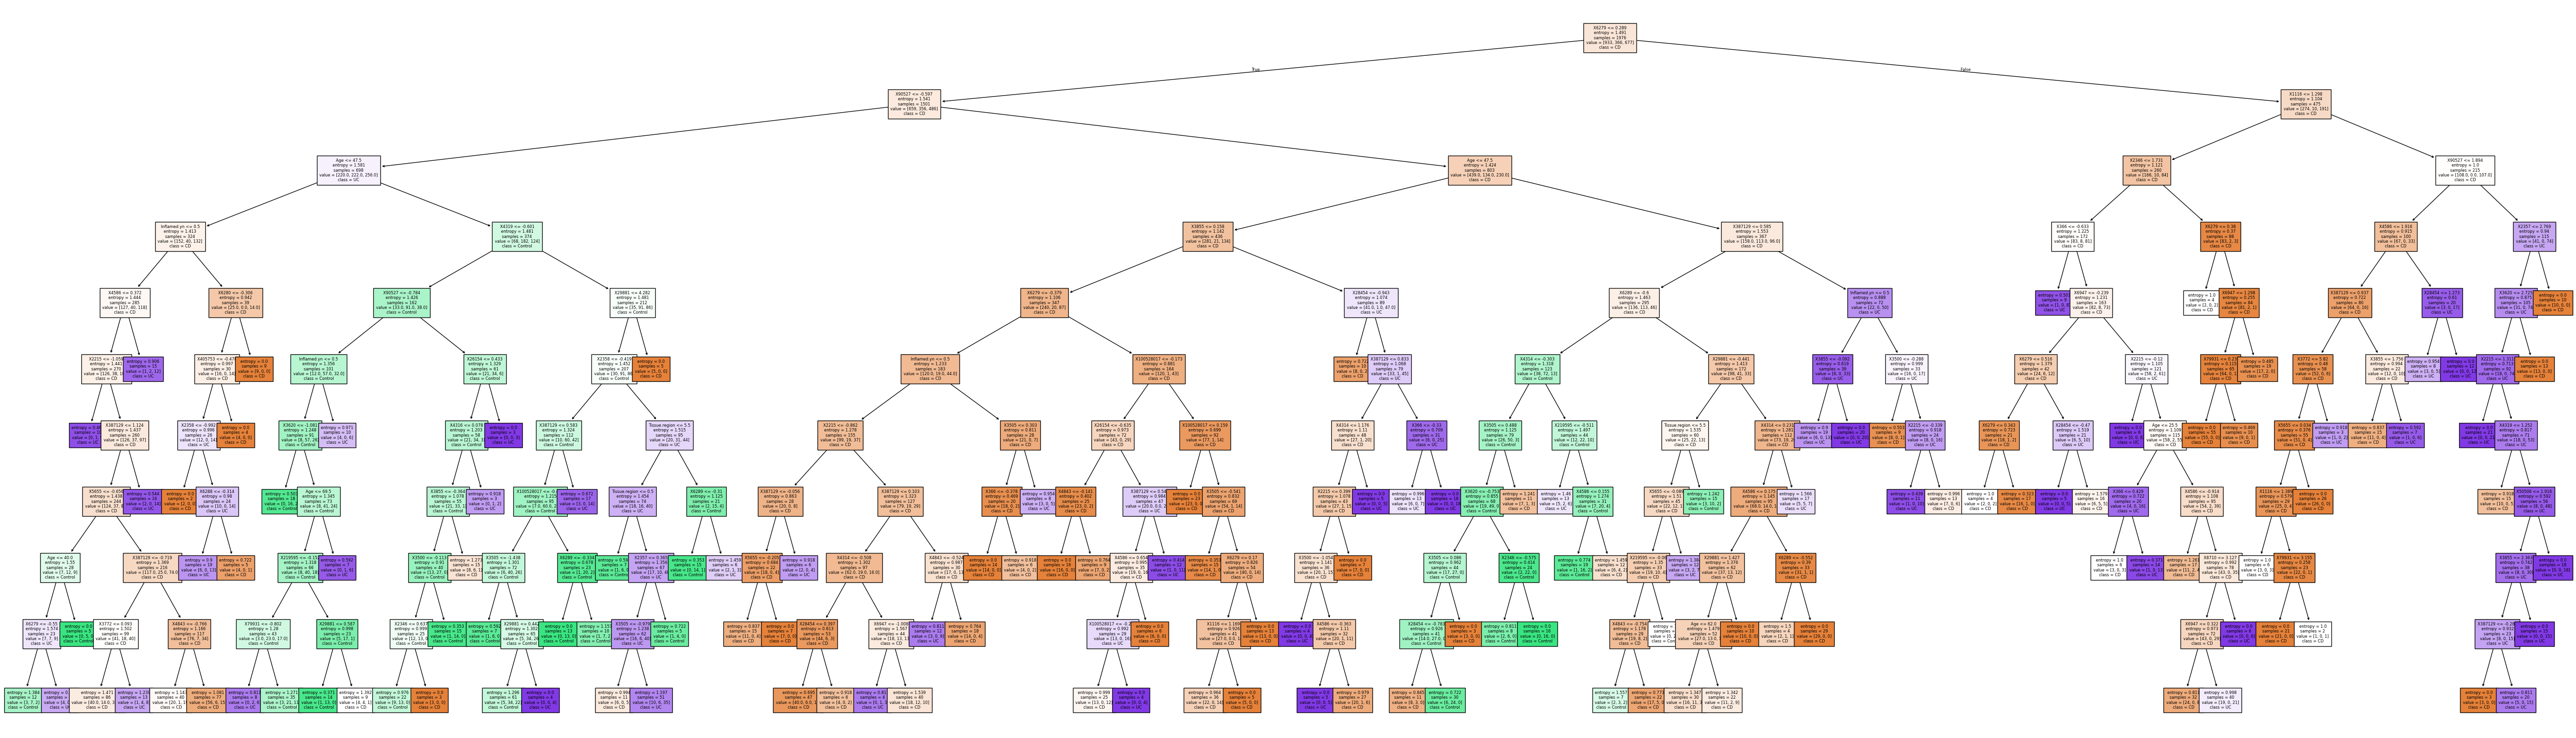

In [ ]:
# use the figure method to set the dimensions of my plot
plt.figure(figsize=(70, 20))

# Plot the tree and color the nodes based on class
plot_tree(best_tree_rem5,
          feature_names=X_rem5_l.columns,  # List of feature names
          class_names=vals_rem5_l,  # List of class names
          filled=True,  # Color nodes based on class
          fontsize=6)  # Adjust font size for better readability

# Save the tree plot to a PDF
plt.savefig("241209_best.dec.tree.pdf", format="pdf", bbox_inches="tight")

# Show the plot if needed
plt.show()

In [ ]:
best_tree_rem5.get_depth()

10

In [ ]:
vals_rem5_l

array(['CD', 'Control', 'UC'], dtype=object)

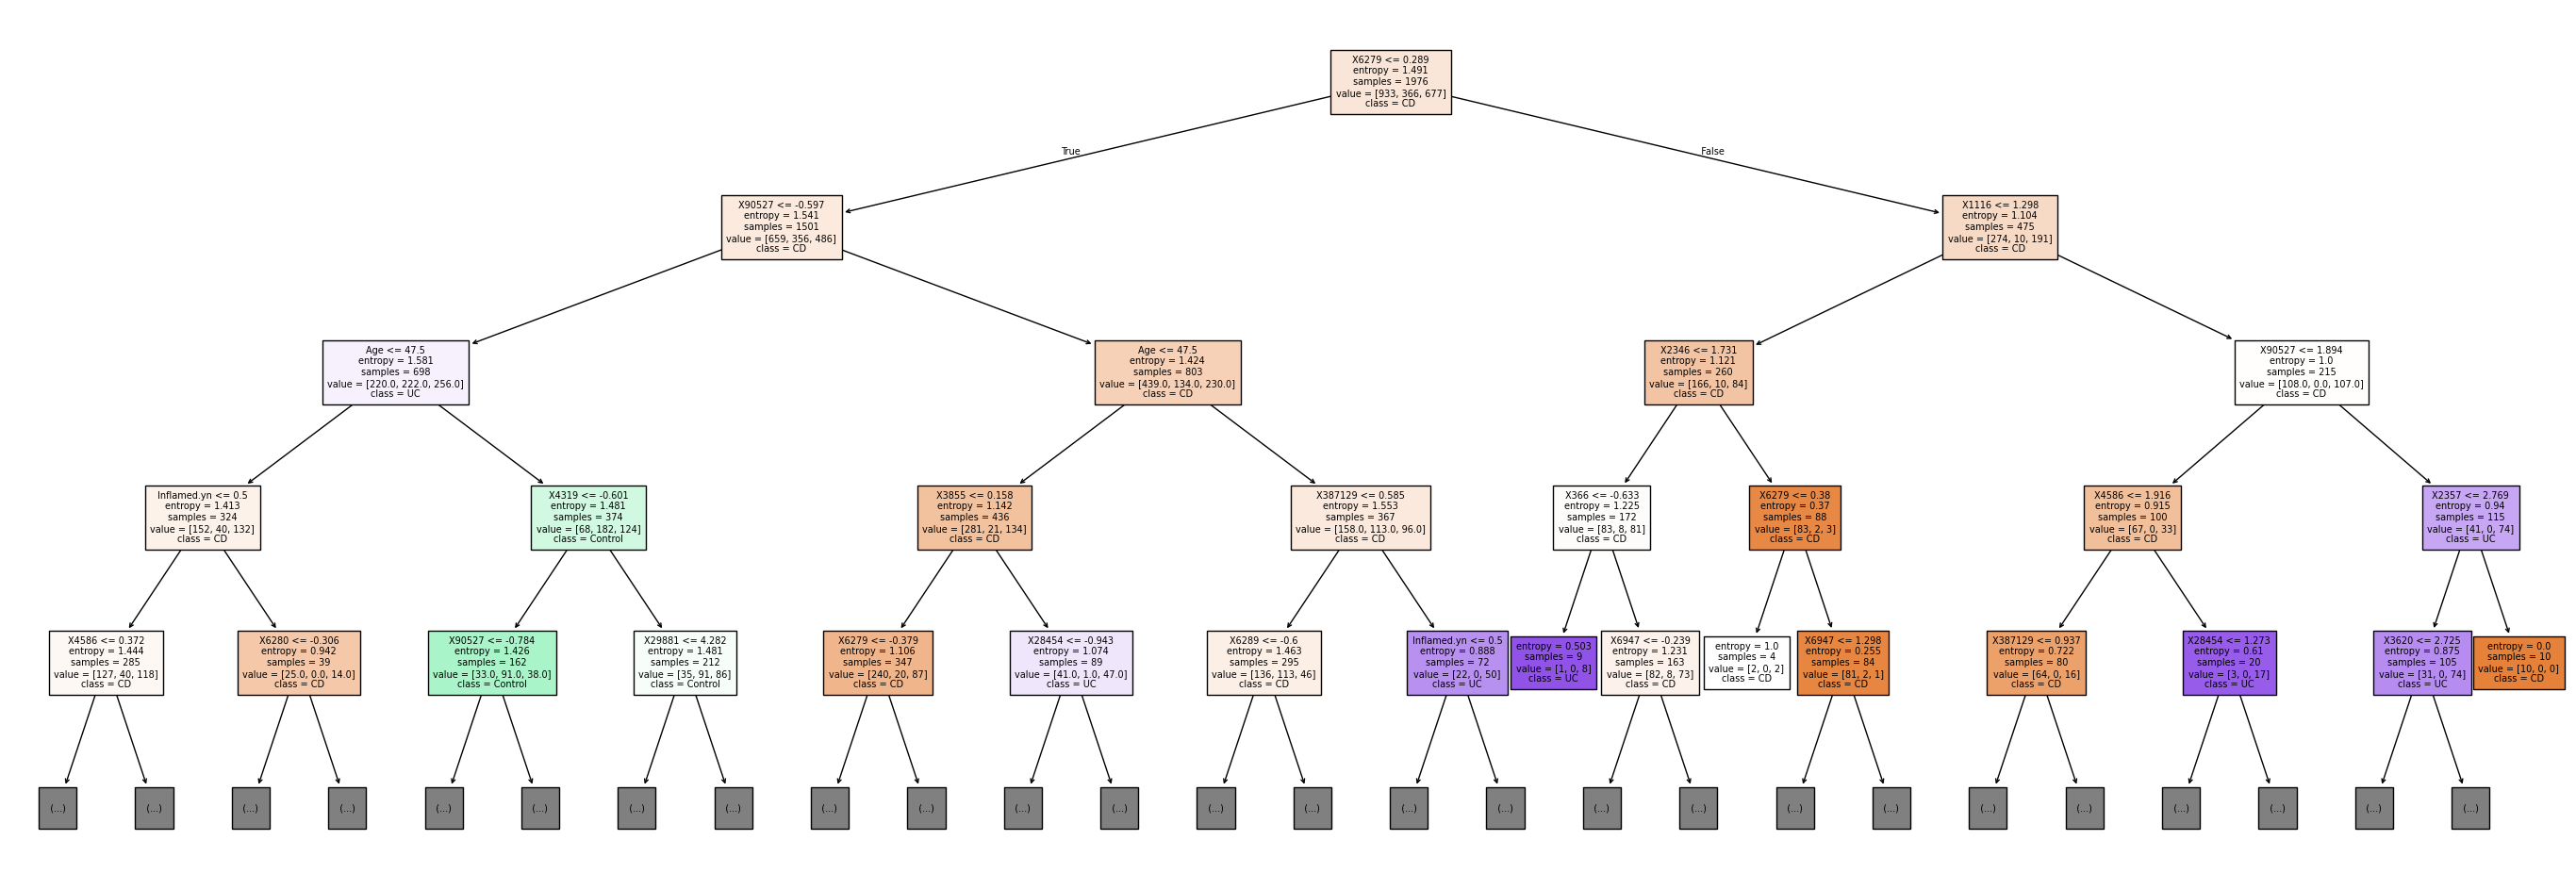

In [ ]:
plt.figure(figsize=(35, 12))  # width, height
plot_tree(best_tree_rem5, max_depth=4,
          filled=True, feature_names=X_rem5_l.columns,
          class_names=vals_rem5_l,
          fontsize=7)

# Save the tree plot to a PDF
plt.savefig("241209_actual.dec.tree.cut4.pdf", format="pdf", bbox_inches="tight")

plt.show()

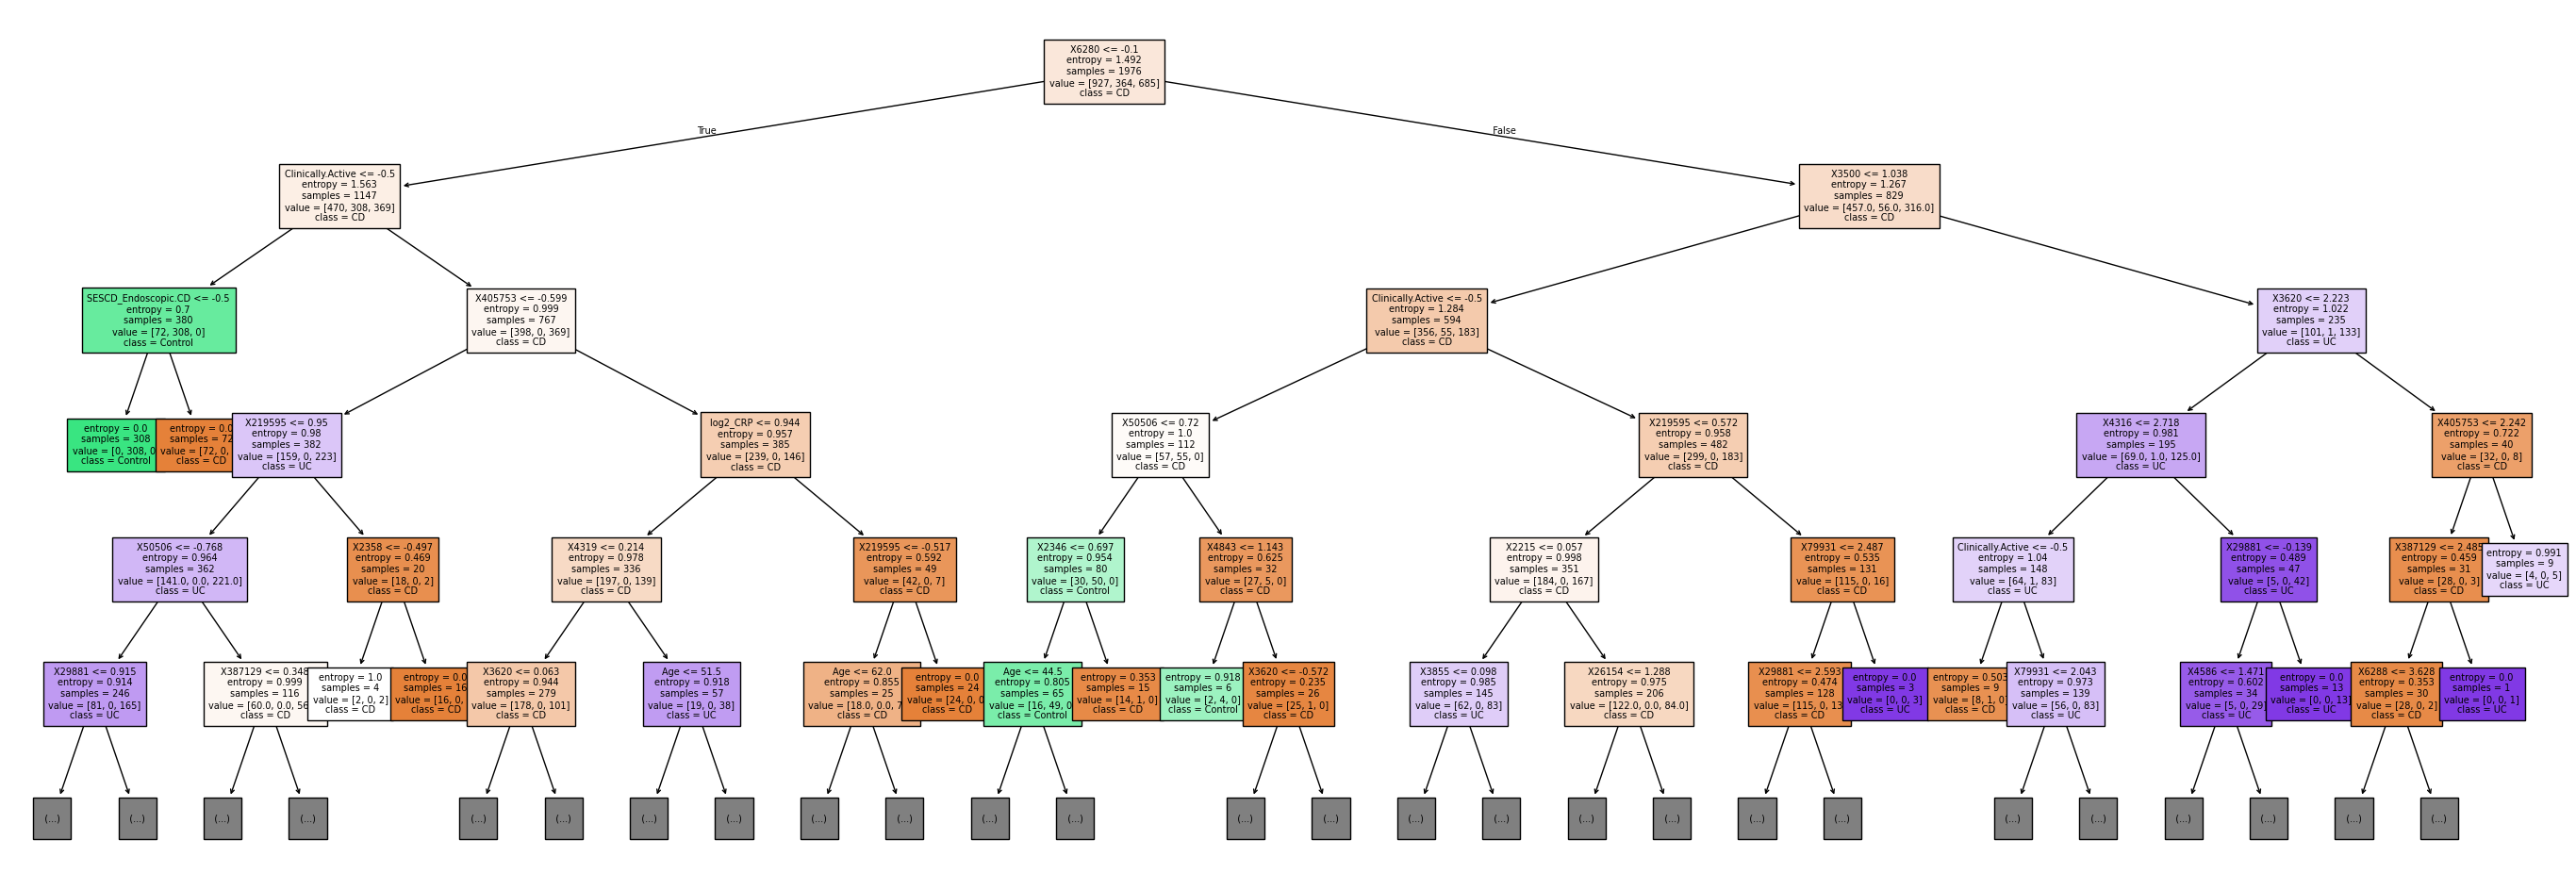

In [ ]:
plt.figure(figsize=(35, 12))  # width, height
plot_tree(best_tree_fitted_l, max_depth=5,
          filled=True, feature_names=X_rem2_l.columns,
          class_names=vals_rem2_l,
          fontsize=7)

# Save the tree plot to a PDF
plt.savefig("241209_dec.tree.cut5.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
param_dist = {
    'criterion':['gini','entropy'], # try both gini and entropy impurity measures
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'] # diff ways to calculate the number of features
                                            # to consider when looking for the best split
}

# Set up RandomizedSearchCV instead of GridSearchCV: checks random combinations instead of
# every possible combination, determine the best combination of hyper parameters by
# evaluating model performance using cross-validation
# StratifiedKFold for cross-validation: data is shuffled before splitting into folds
# to ensure the folds are more representative of the overall data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

random_search_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    verbose=1, # minimal output showing: hyperparameters being tested, cv results for
    # each combination, and how much time each combination is taking
    n_jobs=4,  # Uses 4 out of 11 available cores to speed up computation
    random_state=50
)

#### Random Forest

In [ ]:
# random forest
model_rf = RandomForestClassifier(oob_score = True, random_state=50)

# Set up the hyperparameter search space
param_dist = {
    'criterion':['gini','entropy'], # try both gini and entropy impurity measures
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2'] # diff ways to calculate the number of features
                                            # to consider when looking for the best split
}

# Set up RandomizedSearchCV instead of GridSearchCV: checks random combinations instead of
# every possible combination, determine the best combination of hyper parameters by
# evaluating model performance using cross-validation
# You can use StratifiedKFold for cross-validation to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
# data is shuffled before splitting into folds to ensure the folds are more
# representative of the overall data

random_search_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    verbose=1, # minimal output showing: hyperparameters being tested, cv results for
    # each combination, and how much time each combination is taking
    n_jobs=4,  # Uses 4 out of 11 available cores to speed up computation
    random_state=50
)

# Fit the RandomizedSearchCV to the training data
random_search_rf.fit(X_rem2_train, y_rem2_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
                   estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=50),
                   n_iter=50, n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=50, verbose=1)

In [ ]:
print(random_search_rf.best_score_) # highest accuracy
print(random_search_rf.best_params_) # best combination of hyper parameters
print(random_search_rf.best_estimator_) # this is the best model

0.7894540340109961
{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini'}
RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=5,
                       oob_score=True, random_state=50)


In [ ]:
# set the best estimator to an object and train this object
best_rf = random_search_rf.best_estimator_
best_rf_fitted = best_rf.fit(X_rem2_train, y_rem2_train)
best_rf_fitted

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=5,
                       oob_score=True, random_state=50)

In [ ]:
# the oob score returns the accuracy of the classifier based on the out-of-bag samples
# oob estimates of how well the model generalizes
# out-of-bag samples are data points from the original training set that were not selected for
# a given tree due to the bootstrap nature of random forest
# testing the predictions from these samples acts as a makeshift internal cross validation
best_rf.oob_score_

0.7813765182186235

In [ ]:
# checking the prediction accuracy on the test set with predict and accuracy_score
y_pred_rf2 = best_rf_fitted.predict(X_rem2_test)
accuracy_score(y_rem2_test, y_pred_rf2)

0.8141414141414142

In [ ]:
# checking the prediction accuracy on the test set with predict and accuracy_score
y_pred_rf = best_rf.predict(X_rem2_test)
accuracy_score(y_rem2_test, y_pred_rf)

0.8141414141414142

#### AdaBoost

In [ ]:
# Create adaboost classifer object and try different parameters to see its effect
abc = AdaBoostClassifier(n_estimators=100, # max number of estimators at which boosting is terminated
                         learning_rate=1, # Weight applied to each classifier at each boosting iteration
                         random_state=50,
                         estimator=best_rf,
                         algorithm='SAMME')
# Train Adaboost Classifer with fit method
model_rf_boosted = abc.fit(X_rem2_train, y_rem2_train)

In [ ]:
# Predict the response for test dataset and check accuracy
y_pred_rf_boosted = model_rf_boosted.predict(X_rem2_test)
accuracy_score(y_rem2_test, y_pred_rf_boosted)

0.8121212121212121

In [ ]:
# Create adaboost classifer object and try different parameters to see its effect
abc2 = AdaBoostClassifier(n_estimators=100, # max number of estimators at which boosting is terminated
                         learning_rate=1.5, # Weight applied to each classifier at each boosting iteration
                         random_state=50,
                         estimator=best_rf,
                         algorithm='SAMME')
# Train Adaboost Classifer with fit method
model_rf_boosted2 = abc2.fit(X_rem2_train, y_rem2_train)

# Predict the response for test dataset and check accuracy
y_pred_rf_boosted2 = model_rf_boosted2.predict(X_rem2_test)
accuracy_score(y_rem2_test, y_pred_rf_boosted2)

0.8202020202020202

In [ ]:
# Create adaboost classifer object and try different parameters to see its effect
abc3 = AdaBoostClassifier(n_estimators=150, # max number of estimators at which boosting is terminated
                         learning_rate=1, # Weight applied to each classifier at each boosting iteration
                         random_state=50,
                         estimator=best_rf,
                         algorithm='SAMME')
# Train Adaboost Classifer with fit method
model_rf_boosted3 = abc3.fit(X_rem2_train, y_rem2_train)

# Predict the response for test dataset and check accuracy
y_pred_rf_boosted3 = model_rf_boosted3.predict(X_rem2_test)
accuracy_score(y_rem2_test, y_pred_rf_boosted3)

0.802020202020202

In [ ]:
# Create adaboost classifer object and try different parameters to see its effect
abc4 = AdaBoostClassifier(n_estimators=100, # max number of estimators at which boosting is terminated
                         learning_rate=2, # Weight applied to each classifier at each boosting iteration
                         random_state=50,
                         estimator=best_rf,
                         algorithm='SAMME')
# Train Adaboost Classifer with fit method
model_rf_boosted4 = abc4.fit(X_rem2_train, y_rem2_train)

# Predict the response for test dataset and check accuracy
y_pred_rf_boosted4 = model_rf_boosted4.predict(X_rem2_test)
accuracy_score(y_rem2_test, y_pred_rf_boosted4)

0.8080808080808081

In [ ]:
## The first AdaBoost was the best, yielding 82% prediction accuracy:
### on 41 features (removing instead of replacing 43% NA's with median or mode), 3 of
### the features had 3-26% data replaced with median or mode
### RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=5,
###                       oob_score=True, random_state=50)
### abc2 = AdaBoostClassifier(n_estimators=100, # max number of estimators at which boosting is terminated
###                         learning_rate=1.5, # Weight applied to each classifier at each boosting iteration
###                         random_state=50,
###                         estimator=best_rf,
###                         algorithm='SAMME')

In [ ]:
type(my_svm_pred)

numpy.ndarray

#### XGBoost

In [ ]:
# R used for XGBoost
# Format dataframe for use in XGBoost
# perform VST and normalize data
library(DESeq2)
vst_data = varianceStabilizingTransformation(dds, blind = TRUE)
vst_matrix = assay(vst_data)
z_score_normalized = apply(vst_matrix, 1, function(x) (x - mean(x)) / sd(x))
# put normalized counts back in df with metadata
top_expr = as.data.frame(z_score_normalized[,top_genes])
model_data = cbind(final.meta, top_expr)

In [ ]:
# Select genes for use in model
# Get the number of observations for each class
num_UC = sum(model_data$Disease.type == "UC")
num_CD = sum(model_data$Disease.type == "CD")
num_Control = sum(model_data$Disease.type == "Control")
# Define the number of gene features
num_feat = 35

# Get the number of genes from each disease

# Define the exact nunmber of each genes from UC and CD
mostsig_UC = round(num_feat / 2)
mostsig_CD = num_feat - mostsig_UC

# Get that number of genes
UC_genes = row.names(pval_UC_sort)[1:mostsig_UC]
CD_genes = row.names(pval_CD_sort)[1:mostsig_CD]
unique_genes = unique(UC_genes, CD_genes)

# Get a list of genes equal to the number specified, accounting for genes
# that appear in both diseases
while (length(unique_genes) < num_feat){
  mostsig_UC = mostsig_UC+1
  mostsig_CD = mostsig_CD+1
  next_UC_gene = row.names(pval_UC_sort)[mostsig_UC]
  next_CD_gene = row.names(pval_CD_sort)[mostsig_CD]
  unique_genes = unique(c(unique_genes,next_CD_gene, next_UC_gene))
  if (length(unique_genes) > num_feat){
    unique_genes = unique_genes[-1]
  }
}

# Add genes and selected metadata to dataframe
features = c(colnames(model_data)[1:5],unique_genes)
feat_data = model_data[,paste0("X",features[6:length(features)])]
feat_data = cbind(model_data[,features[1:5]],feat_data)
labels = model_data$Disease.type
feat_data$Disease.type = as.factor(feat_data$Disease.type)
feat_data$Sex = as.factor(feat_data$Sex)
feat_data$Tissue.region = as.factor(feat_data$Tissue.region)
feat_data$Inflamed.yn = as.factor(feat_data$Inflamed.yn)

In [ ]:
library(xgboost)
library(caret)

#Make labels numeric (Eg. 0, 1 ,2)
labels = as.numeric(factor(feat_data$Disease.type, levels = c("Control","CD","UC")))-1

# Do One-hot encoding for categorical variables
encoded_sex = model.matrix(~ Sex - 1, data = feat_data)
encoded_tis = model.matrix(~ Tissue.region - 1, data = feat_data)
encoded_inf = model.matrix(~ Inflamed.yn - 1, data = feat_data)
encoded_df = cbind(encoded_sex,encoded_tis,encoded_inf,feat_data[,-c(1:5)])

# Make training test splits
train_id = createDataPartition(feat_data$Disease.type, p = 0.8, list = FALSE)
train_data = encoded_df[train_id,-1]
test_data = encoded_df[-train_id,-1]
train_label = labels[train_id]
test_label = labels[-train_id]
data_matrix = as.matrix(train_data)

# Make XGB matrix object for training
train_xgb_matrix = xgb.DMatrix(
  data = as.matrix(train_data),
  label = train_label,
  missing = NA)

# And testing
test_xgb_matrix = xgb.DMatrix(
  data = as.matrix(test_data),
  label = test_label,
  missing = NA)

In [ ]:
# Optimize model parameters
library(caret)
# Make a grid of parameters to test
params_grid = expand.grid(
  nrounds = c(2, 5, 10),
  eta = c(0.01, 0.3, 0.5),
  max_depth = c(3, 6, 9),
  gamma = c(0, 1, 5),
  min_child_weight = c(1, 5, 10),
  subsample = c(0.5, 0.75, 1),
  colsample_bytree = c(0.5, 0.75, 1)
)
# Define train control parameter
train_control = trainControl(
  method = 'cv',
  number = 5,
  verboseIter = F,
  allowParallel = T
)
options(warn = -1)
# Use grid search
  xgb_grid = suppressWarnings(train(
  x = as.matrix(train_df[1:500,]),
  y = as.factor(train_label[1:500]),
  method = "xgbTree",
  trControl = train_control,
  tuneGrid = params_grid,
  metric = "Accuracy",
  verbose = 0
  ))


xgb_grid$bestTune

In [ ]:
# Evaluate on test set
params = list(
  max_depth =10,
  eta = 0.3,
  gamma = 1,
  colsample_bytree = 1,
  min_child_weight = 5,
  subsample = 1)
nrounds = 15
xgb_model = xgboost(
  data = train_xgb_matrix,
  params = params,
  nrounds = nrounds,
  verbose = 1,
  objective = "multi:softmax",
  num_class = 3)

# Test
pred = predict(xgb_model, test_xgb_matrix)
accuracy = sum(pred == test_label) / length(test_label)
print(paste("multi-class Accuracy:", round(accuracy * 100, 2), "%"))


In [ ]:
# Generate ROC curves
library(pROC)
library(xgboost)
# Initialize variables
roc_curves = list()
auc_values = numeric()

# Train model again, this time getting probabilities
xgb_model = xgboost(
  data = train_xgb_matrix,
  params = params,
  nrounds = nrounds,
  verbose = 1,
  num_class = 3,
  objective = "multi:softprob")
# Predict probabilities on the test set
pred_probs = predict(xgb_model, test_xgb_matrix)
pred_probs_matrix = matrix(pred_probs, ncol = 3, byrow = TRUE)

for (class in c(0, 1, 2)) {
  # Create binary labels for one-vs-all
  binary_labels = ifelse(test_label == class, 1, 0)

  # Get probabilities for the current class
  class_probs = pred_probs_matrix[, class + 1]

  # Get ROC and AUC
  roc_curves[[class + 1]] = roc(binary_labels, class_probs)
  auc_values[class + 1] = auc(roc_curves[[class + 1]])
}

# Plot ROC curves for all classes
plot(roc_curves[[1]], col = "red", main = "ROC Curves using XGBoost")
plot(roc_curves[[2]], col = "blue", add = TRUE)
plot(roc_curves[[3]], col = "green", add = TRUE)

# Add a legend
legend("bottomright", legend = c("Control", "CD", "UC"), col = c("red", "blue", "green"), lwd = 2)

In [ ]:
# Get metrics
conf_matrix = confusionMatrix(as.factor(pred), as.factor(test_label))
precision = conf_matrix$byClass[, "Precision"]
recall = conf_matrix$byClass[, "Recall"]
f1 = conf_matrix$byClass[, "F1"]
metrics = data.frame(
  Precision = precision,
  Recall = recall,
  F1 = f1,
  AUC = auc_values
)
row.names(metrics) = c("Control","CD","UC")
library(knitr)
kable(metrics, caption = "Evaluation Metrics", digits = 2)

#### Pickle and Metrics

In [ ]:
import pickle

# Specify the objects you want to save
workspace = {name: value for name, value in globals().items()
             if isinstance(value, (pd.DataFrame, np.ndarray, DecisionTreeClassifier,
                                   RandomForestClassifier, AdaBoostClassifier, SVC, LinearSVC))}

# Save the selected objects to a pickle file
with open('/content/241208_workspace.pkl', 'wb') as f:
    pickle.dump(workspace, f)

## This is unnecessary, just downloading it from the file list is much faster
# Download the pickle file (for Google Colab)
# from google.colab import files
# files.download('/content/241208_workspace.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# re-access the workspace:
import pickle
with open('/Users/collad04/Downloads/241208_workspace.pkl', 'rb') as f:
    loaded_workspace = pickle.load(f)

## example of re-loading
y_rem2_test = loaded_workspace['y_rem2_test']
y_pred_rf_boosted2 = loaded_workspace['y_pred_rf_boosted2']

accuracy_score(y_rem2_test, y_pred_rf_boosted2)

In [ ]:
## To re-access the workspace:

# Re-upload the pickle file
from google.colab import files
uploaded = files.upload()

# Load the objects from the pickle file
with open('241208_workspace.pkl', 'rb') as f:
    loaded_objects = pickle.load(f)

## Accessing the objects from the loaded workspace
# random_search_rf_loaded = loaded_workspace['random_search_rf']
# X_rem2_loaded = loaded_workspace['X_rem2']
# y_rem2_loaded = loaded_workspace['y_rem2']

In [ ]:
y_rem2_test_l = loaded_objects['y_rem2_test']
   # myresdf, # dataframe of SVM trials
    # mysvm,
my_svm_pred_l = loaded_objects['my_svm_pred'] # fitted svm and prediction result
    # best_tree_fitted,
best_tree_pred_l = loaded_objects['best_tree_pred'] # fitted dec tree and prediction
    # best_rf_fitted,
y_pred_rf2_l = loaded_objects['y_pred_rf2'] # fitted random forest and prediction
    # model_rf_boosted2,
y_pred_rf_boosted_l = loaded_objects['y_pred_rf_boosted2']

In [ ]:
y_rem2_test_l

array([2, 0, 1, 2, 1, 1, 1, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0,
       2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2,
       0, 1, 1, 2, 1, 0, 0, 1, 0, 2, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 0,
       1, 0, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 0, 2,
       2, 1, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 2, 1, 2, 0, 2, 2, 2, 1, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 2,
       0, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 0, 1,
       1, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 2, 0,
       2, 1, 0, 0, 2, 0, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2,
       1, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2,
       0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1,

In [ ]:
my_svm_pred_l

array([2, 2, 1, 2, 1, 1, 1, 2, 0, 0, 2, 0, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0,
       1, 1, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 1, 0, 0,
       2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2,
       0, 1, 1, 2, 1, 0, 0, 1, 2, 2, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 0,
       1, 0, 0, 0, 1, 0, 2, 2, 2, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 0, 2,
       2, 1, 0, 0, 1, 0, 2, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 2, 0, 0,
       2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2,
       0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1,
       1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 2, 0,
       0, 1, 2, 0, 2, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2,
       1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1,

In [ ]:
best_tree_pred_l

array([2, 0, 1, 2, 1, 1, 1, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 2, 2,
       2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2,
       0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 0, 1, 2, 2, 2, 2,
       1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 1, 2, 0, 2, 0, 2, 1, 2, 0, 0, 1, 0, 2, 1, 1, 2, 2, 0,
       0, 0, 2, 0, 1, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 1, 1, 0, 2, 2, 2, 0, 1, 0, 1,
       1, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0,
       2, 1, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 0, 2, 2, 0, 2, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0, 1,

In [ ]:
y_pred_rf2_l

array([0, 2, 1, 2, 1, 1, 1, 0, 2, 0, 2, 0, 2, 1, 2, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 0, 1, 0, 2,
       2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2,
       0, 1, 1, 2, 1, 0, 0, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 1, 2, 2, 2, 0,
       1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 2, 0, 1, 1, 0, 2, 0, 2, 0, 0, 0, 2,
       2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2,
       0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 1,
       1, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 0,
       2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2,
       1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2,
       0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1,

In [ ]:
y_pred_rf_boosted_l

array([2, 2, 1, 2, 1, 1, 1, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 2,
       2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2,
       0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 0, 1, 2, 2, 2, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 2, 0, 1, 1, 0, 2, 2, 2, 0, 0, 0, 2,
       2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2,
       0, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 0, 1,
       1, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 0, 0,
       0, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2,
       1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 2,
       0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1, 0, 1,

In [ ]:
import pickle

# Create a dictionary to store multiple objects
objects_to_save = [
    X_rem2, X_rem2_train, X_rem2_test,
    y_rem2, y_rem2_train, y_rem2_test,
    myresdf, # dataframe of SVM trials
    mysvm, my_svm_pred, # fitted svm and prediction result
    best_tree_fitted, best_tree_pred, # fitted dec tree and prediction
    best_rf_fitted, y_pred_rf2, # fitted random forest and prediction
    model_rf_boosted2, y_pred_rf_boosted2 # adaboosted random forest and prediction: 82%
]


# Saving all objects in the workspace to a file
with open('241208_objects.pkl', 'wb') as f:
    pickle.dump(objects_to_save, f)

# Download the pickle file
from google.colab import files
files.download('/content/241208_objects.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## To re-access the objects:
# Re-upload the pickle file
from google.colab import files
uploaded = files.upload()

# Load the objects from the pickle file
with open('workspace.pkl', 'rb') as f:
    loaded_objects = pickle.load(f)

## Access the loaded objects (they are now in the same order as the original list)
# rf_model_loaded = loaded_objects[0]
# X_rem2_loaded = loaded_objects[1]


In [ ]:
# Metrics
conf_matrix = confusionMatrix(as.factor(pred), as.factor(test_label))
precision = conf_matrix$byClass[, "Precision"]
recall = conf_matrix$byClass[, "Recall"]
f1 = conf_matrix$byClass[, "F1"]
metrics = data.frame(
  Precision = precision,
  Recall = recall,
  F1 = f1,
  AUC = auc_values
)
row.names(metrics) = c("Control","CD","UC")
library(knitr)
kable(metrics, caption = "Evaluation Metrics", digits = 2)

In [ ]:
# ROC curve
for (class in c(0, 1, 2)) {
  # Create binary labels for one-vs-all
  binary_labels = ifelse(test_label == class, 1, 0)

  # Get probabilities for the current class
  class_probs = pred_probs_matrix[, class + 1]

  # Compute ROC and AUC
  roc_curves[[class + 1]] = roc(binary_labels, class_probs)
  auc_values[class + 1] = auc(roc_curves[[class + 1]])
}

# Plot ROC curves for all classes
plot(roc_curves[[1]], col = "red", main = "ROC Curves")
plot(roc_curves[[2]], col = "blue", add = TRUE)
plot(roc_curves[[3]], col = "green", add = TRUE)

# Add a legend
legend("bottomright", legend = c("Control", "CD", "UC"), col = c("red", "blue", "green"), lwd = 2)


In [1]:
import os

os.system('jupyter nbconvert --to html Machine_Learning_Final_Project (2).ipynb')

1